# 🛠 Install Libraries

In [1]:
!pip install -q segmentation_models_pytorch
!pip install -qU wandb
!pip install -q scikit-learn==1.0

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pdpbox 0.2.1 requires matplotlib==3.1.1, but you have matplotlib 3.5.1 which is incompatible.
imbalanced-learn 0.9.0 requires scikit-learn>=1.0.1, but you have scikit-learn 1.0 which is incompatible.
featuretools 1.6.0 requires numpy>=1.21.0, but you have numpy 1.20.3 which is incompatible.


# 📚 Import Libraries 

In [2]:
import numpy as np
import pandas as pd
pd.options.plotting.backend = "plotly"
import random
from glob import glob
import os, shutil
from tqdm import tqdm
tqdm.pandas()
import time
import copy
import joblib
from collections import defaultdict
import gc
from IPython import display as ipd
import math
import wandb

# visualization
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

# Sklearn
from sklearn.model_selection import StratifiedKFold, KFold, StratifiedGroupKFold
from sklearn.model_selection import train_test_split

# PyTorch 
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader
from torch.cuda import amp
from torch.utils.data import Dataset
import segmentation_models_pytorch
import timm

# Albumentations for augmentations
import albumentations as A
from albumentations.pytorch import ToTensorV2

import rasterio
from joblib import Parallel, delayed

# For colored terminal text
from colorama import Fore, Back, Style
c_  = Fore.GREEN
sr_ = Style.RESET_ALL

# OpenCV
import cv2
from cv2 import imread, createCLAHE 

import warnings
warnings.filterwarnings("ignore")

# For descriptive error messages
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

# ⚙️ Configuration 

In [3]:
class CFG:
    seed          = 2022
    debug         = False # set debug=False for Full Training
    exp_name      = 'Baselinev2'
    comment       = 'unet-efficientnet_b1-224x224'
    model_name    = 'Unet'
    backbone      = 'efficientnet-b1'
    train_bs      = 40
    valid_bs      = train_bs*2
    img_size      = [224, 224]
    epochs        = 500
    lr            = 2e-3
    scheduler     = 'CosineAnnealingLR'
    min_lr        = 1e-6
    T_max         = int(30000/train_bs*epochs)+50
    T_0           = 25
    warmup_epochs = 0
    wd            = 1e-6
    n_fold        = 5
    num_classes   = 1
    device        = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

def set_seed(seed):
    '''Sets the seed of the entire notebook so results are the same every time we run.
    This is for REPRODUCIBILITY.'''
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # Set a fixed value for the hash seed
    os.environ['PYTHONHASHSEED'] = str(seed)
    print('> SEEDING DONE')
    
set_seed(CFG.seed)

> SEEDING DONE


# 📖 Dataset Generation

In [4]:
class BuildDataset(Dataset):
    def __init__(self, img_path, mask_path, label, transforms):
        length = 0
        img_paths = []
        mask_paths = []
        img_path_list = os.listdir(img_path)
        len_list = len(img_path_list)
        if label == "train":
            img_path_list = img_path_list[0:round(0.8*len_list)]
        if label == "valid":
            img_path_list = img_path_list[round(0.8*len_list)+1:round(1*len_list)]
        for i in img_path_list:
            for j in os.listdir(os.path.join(img_path,i)):      
                length = length + 1
                img_paths.append(os.path.join(img_path,i,j))
                mask_paths.append(os.path.join(mask_path,i,j))
        self.img_paths = img_paths
        self.mask_paths = mask_paths
        self.length = length
        self.transforms = transforms[label]
    def __len__(self):
        return self.length
    def __getitem__(self, index):
        img_path  = "".join(self.img_paths[index])
        img = cv2.imread(img_path)[:,:,0]
        img = img.astype('float32') # original is uint16     
        mask_path = "".join(self.mask_paths[index])
        mask = cv2.imread(mask_path)[:,:,0]
        mask = mask.astype('float32') # original is uint16    
        data = self.transforms(image=img, mask=mask)
        img  = data['image']
        mask  = data['mask']
        return img, mask
    
data_transforms = {
    "train": A.Compose([
        A.Resize(*CFG.img_size),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.05, rotate_limit=5, p=0.5),
        A.OneOf([
            A.GridDistortion(num_steps=5, distort_limit=0.05, p=1.0),
            A.OpticalDistortion(distort_limit=0.05, shift_limit=0.05, p=1.0),
            A.ElasticTransform(alpha=1, sigma=50, alpha_affine=50, p=1.0)
        ], p=0.25),
        A.CoarseDropout(max_holes=8, max_height=CFG.img_size[0]//20, max_width=CFG.img_size[1]//20,
                         min_holes=5, fill_value=0, mask_fill_value=0, p=0.5),
        ToTensorV2()], p=1.0),
    
    "valid": A.Compose([
        A.Resize(*CFG.img_size),
        ToTensorV2()], p=1.0)
}

# 📈 Visualization

In [5]:
def plot_batch(imgs, msks, img_number, size):
    plt.figure(figsize=(size*size, img_number))
    for idx in range(img_number):
        plt.subplot(round(img_number/size),size, idx+1)
        img = imgs[idx,].numpy()
        img = img.astype('uint8')
        msk = msks[idx,].numpy()
        plt.imshow(img, cmap='bone')
        plt.imshow(msk, alpha=0.6)
    plt.tight_layout()
    plt.show()

# 📦 Model

In [6]:
def build_model():
    model = segmentation_models_pytorch.Unet(
        encoder_name=CFG.backbone,      # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
        encoder_weights="imagenet",     # use `imagenet` pre-trained weights for encoder initialization
        in_channels=1,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
        classes=CFG.num_classes,        # model output channels (number of classes in your dataset)
        activation=None,
    )
    model.to(CFG.device)
    return model

def fetch_scheduler(optimizer, mode):
    if mode == 'CosineAnnealingLR':
        scheduler = lr_scheduler.CosineAnnealingLR(optimizer,T_max=CFG.T_max, 
                                                   eta_min=CFG.min_lr)
    elif mode == 'CosineAnnealingWarmRestarts':
        scheduler = lr_scheduler.CosineAnnealingWarmRestarts(optimizer,T_0=CFG.T_0, 
                                                             eta_min=CFG.min_lr)
    elif mode == 'ReduceLROnPlateau':
        scheduler = lr_scheduler.ReduceLROnPlateau(optimizer,
                                                   mode='min',
                                                   factor=0.1,
                                                   patience=7,
                                                   threshold=0.0001,
                                                   min_lr=CFG.min_lr,)
    elif mode == 'ExponentialLR':
        scheduler = lr_scheduler.ExponentialLR(optimizer, gamma=0.85)
    elif mode == None:
        return None
        
    return scheduler

model = build_model()
optimizer = optim.Adam(model.parameters(), lr=CFG.lr, weight_decay=CFG.wd)
scheduler = fetch_scheduler(optimizer,CFG.scheduler)

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b1-f1951068.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b1-f1951068.pth


  0%|          | 0.00/30.1M [00:00<?, ?B/s]

# ⭐ WandB

<img src="https://camo.githubusercontent.com/dd842f7b0be57140e68b2ab9cb007992acd131c48284eaf6b1aca758bfea358b/68747470733a2f2f692e696d6775722e636f6d2f52557469567a482e706e67" width="400" alt="Weights & Biases" />

Weights & Biases (W&B) is MLOps platform for tracking our experiemnts. We can use it to Build better models faster with experiment tracking, dataset versioning, and model management. Some of the cool features of **W&B**:

* Track, compare, and visualize ML experiments
* Get live metrics, terminal logs, and system stats streamed to the centralized dashboard.
* Explain how your model works, show graphs of how model versions improved, discuss bugs, and demonstrate progress towards milestones.

In [7]:
import wandb
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
api_key = user_secrets.get_secret("WANDB")
wandb.login(key=api_key)
anonymous = None

wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


# 🔧 Loss Function

In [8]:
#JaccardLoss = segmentation_models_pytorch.losses.JaccardLoss(mode='binary')
DiceLoss    = segmentation_models_pytorch.losses.DiceLoss(mode='binary')
BCELoss     = segmentation_models_pytorch.losses.SoftBCEWithLogitsLoss()
LovaszLoss  = segmentation_models_pytorch.losses.LovaszLoss(mode='binary', per_image=False)
TverskyLoss = segmentation_models_pytorch.losses.TverskyLoss(mode='binary', log_loss=False, alpha = 0.95, beta = 0.05)

def dice_coef(y_true, y_pred, thr=0.95, epsilon=0.001):
    y_true = (y_true>thr).to(torch.float32)
    y_pred = (y_pred>thr).to(torch.float32)
    inter = torch.sum(y_true*y_pred)
    den = torch.sum(y_true) + torch.sum(y_pred)
    dice = ((2*inter+epsilon)/(den+epsilon))
    return dice

def iou_coef(y_true, y_pred, thr=0.95, epsilon=0.001):
    y_true = (y_true>thr).to(torch.float32)
    y_pred = (y_pred>thr).to(torch.float32)
    inter = torch.sum(y_true*y_pred)
    union = torch.sum(y_true + y_pred - y_true*y_pred)
    iou = ((inter+epsilon)/(union+epsilon))
    return iou



def criterion(y_pred, y_true):
#    return 0.5*BCELoss(y_pred, y_true) + 0.5*TverskyLoss(y_pred, y_true)
#    return 0.1*DiceLoss(y_pred, y_true) + 0.9*JaccardLoss(y_pred, y_true)
    return TverskyLoss(y_pred, y_true)


# 🚅 Training

train_image, train_mask = next(iter(train_dataset_loader))
train_image = train_image.to(CFG.device, dtype=torch.float)
y_pred = model(train_image)
y_pred_1 = y_pred.cpu()
y_pred_2 = y_pred_1.detach().numpy()
def plot_batch(imgs, msks, img_number, size):
    plt.figure(figsize=(size*size, img_number))
    for idx in range(img_number):
        plt.subplot(round(img_number/size),size, idx+1)
        img = imgs[idx,]
        img = img.astype('uint8')
        msk = msks[idx,].numpy()
        plt.imshow(img, cmap='bone')
        plt.imshow(msk, alpha=0.6)
    plt.tight_layout()
    plt.show()
plot_batch(y_pred_2.squeeze(1), train_mask.squeeze(1), 25, 5)
BCELoss = segmentation_models_pytorch.losses.SoftBCEWithLogitsLoss()
TverskyLoss = segmentation_models_pytorch.losses.TverskyLoss(mode='multilabel', log_loss=False)
loss = 0.5*BCELoss(y_pred.squeeze(1), train_mask) + 0.5*TverskyLoss(y_pred.squeeze(1), train_mask)
rain_mask = train_mask.to(CFG.device, dtype=torch.float)
torch.cuda.empty_cache()

In [9]:
img_path = "../input/cbct-cut-relax/CT_tif_cut"
mask_path = "../input/cbct-cut-relax/GT_tif_cut"
train_dataset = BuildDataset(img_path, mask_path,"train",data_transforms)
train_dataset_loader = DataLoader(train_dataset, batch_size=CFG.train_bs, num_workers=4, shuffle=True, pin_memory=True, drop_last=True)
valid_dataset = BuildDataset(img_path, mask_path,"valid",data_transforms)
valid_dataset_loader = DataLoader(valid_dataset, batch_size=CFG.valid_bs, num_workers=4, shuffle=False, pin_memory=True) 
run = wandb.init(project='tooth segmentatio',config={k:v for k, v in dict(vars(CFG)).items() if '__' not in k},anonymous=anonymous,name=f"fold-|dim-{CFG.img_size[0]}x{CFG.img_size[1]}|model-{CFG.model_name}",group=CFG.comment,)
if torch.cuda.is_available():
    print("cuda: {}\n".format(torch.cuda.get_device_name()))
start = time.time()
best_model_wts = copy.deepcopy(model.state_dict())
best_dice = -np.inf
best_epoch = -1
history = defaultdict(list) # store data values like a map

wandb: Currently logged in as: benxiang-jiang. Use `wandb login --relogin` to force relogin


cuda: Tesla P100-PCIE-16GB



In [10]:
for epoch in range(1, CFG.epochs + 1): 
    gc.collect() #clear variables and objects
    print(f'Epoch {epoch}/{CFG.epochs}', end='')
    # train one epoch
    model.train() #open batch normalization and drop out
    scaler = amp.GradScaler() #automatic mixed precision for scaler; help perform the steps of gradient scaling conveniently
    train_scores = []
    dataset_size = 0
    running_loss = 0.0
    pbar = tqdm(enumerate(train_dataset_loader), total=len(train_dataset_loader), desc='Train') # show progress #enumerate dataloader
    for step, (images, masks) in pbar:
        with amp.autocast(enabled=True): #automatic mixed precision for tensor; 不清楚为啥用with，但是先学吧
            images = images.to(CFG.device, dtype=torch.float)
            masks  = masks.to(CFG.device, dtype=torch.float)
            #batch_size = images.size(0)
            y_pred = model(images).squeeze(1)
            loss = criterion(y_pred, masks)
            scaler.scale(loss).backward() #normalization and backward propagation
            scaler.step(optimizer)
            scaler.update() #update parameters
            optimizer.zero_grad() # zero the parameter gradients
            scheduler.step() #change learning rate with scheduler
            #running_loss += (loss.item() * zz)
            #dataset_size += batch_size
            #train_loss = running_loss / dataset_size
            train_loss = loss.item()
            train_dice = dice_coef(masks, y_pred).cpu().detach().numpy()
            train_jaccard = iou_coef(masks, y_pred).cpu().detach().numpy()
            train_scores.append([train_dice, train_jaccard])
            mem = torch.cuda.memory_reserved() / 1E9 if torch.cuda.is_available() else 0
            current_lr = optimizer.param_groups[0]['lr']
            pbar.set_postfix(train_loss=f'{train_loss:0.4f}',lr=f'{current_lr:0.5f}',gpu_mem=f'{mem:0.2f} GB')
    train_scores  = np.mean(train_scores, axis=0)
    train_dice, train_jaccard = train_scores
    torch.cuda.empty_cache()
    gc.collect()
    # valid one epoch
    with torch.no_grad(): #turn off gradients computation
        model.eval() #close batch normalization and drop out
        dataset_size = 0
        running_loss = 0.
        val_scores = []
        pbar = tqdm(enumerate(valid_dataset_loader), total=len(valid_dataset_loader), desc='Valid') # show progress #enumerate dataloader
        for step, (images, masks) in pbar:
            images = images.to(CFG.device, dtype=torch.float)
            masks  = masks.to(CFG.device, dtype=torch.float)
            #batch_size = images.size(0)
            y_pred = model(images).squeeze(1)
            loss = criterion(y_pred, masks)
            #running_loss += (loss.item() * batch_size)
            #dataset_size += batch_size
            #val_loss = running_loss / dataset_size
            val_loss = loss.item()
            y_pred = nn.Sigmoid()(y_pred)
            val_dice = dice_coef(masks, y_pred).cpu().detach().numpy()
            val_jaccard = iou_coef(masks, y_pred).cpu().detach().numpy()
            val_scores.append([val_dice, val_jaccard])
            mem = torch.cuda.memory_reserved() / 1E9 if torch.cuda.is_available() else 0
            current_lr = optimizer.param_groups[0]['lr']
            pbar.set_postfix(val_loss=f'{val_loss:0.4f}',lr=f'{current_lr:0.5f}',gpu_mem=f'{mem:0.2f} GB')
    val_scores  = np.mean(val_scores, axis=0)
    torch.cuda.empty_cache()
    gc.collect()
    val_dice, val_jaccard = val_scores
    
    # history
    history['Train Loss'].append(train_loss)
    history['Valid Loss'].append(val_loss)
    history['Train Dice'].append(train_dice)
    history['Train Jaccard'].append(train_jaccard)
    history['Valid Dice'].append(val_dice)
    history['Valid Jaccard'].append(val_jaccard)
    
    # Log the metrics
    #wandb.log({"Train Loss": train_loss,"Valid Loss": val_loss,"Valid Dice": val_dice,"Valid Jaccard": val_jaccard,"LR":scheduler.get_last_lr()[0]})
    print(f'Train Dice: {train_dice:0.4f} |Train Jaccard: {train_jaccard:0.4f} |Valid Dice: {val_dice:0.4f} | Valid Jaccard: {val_jaccard:0.4f}')
    
    # deep copy the model
    if val_dice >= best_dice:
        print(f"{c_}Valid Score Improved ({best_dice:0.4f} ---> {val_dice:0.4f})")
        best_dice    = val_dice
        best_jaccard = val_jaccard
        best_epoch   = epoch
        run.summary["Best Dice"]    = best_dice
        run.summary["Best Jaccard"] = best_jaccard
        run.summary["Best Epoch"]   = best_epoch
        best_model_wts = copy.deepcopy(model.state_dict())
        PATH = f"best_epoch.bin"
        torch.save(model.state_dict(), PATH)
        # Save a model file from the current directory
        wandb.save(PATH)
        print(f"Model Saved{sr_}")
    last_model_wts = copy.deepcopy(model.state_dict())
    PATH = f"last_epoch.bin"
    torch.save(model.state_dict(), PATH)
    print(); print()

# end training
end = time.time()
time_elapsed = end - start
print('Training complete in {:.0f}h {:.0f}m {:.0f}s'.format(
    time_elapsed // 3600, (time_elapsed % 3600) // 60, (time_elapsed % 3600) % 60))
print("Best Score: {:.4f}".format(best_jaccard))

# load best model weights
model.load_state_dict(best_model_wts)

#run.finish()
display(ipd.IFrame(run.url, width=1000, height=720))

Epoch 1/500

Valid: 100%|██████████| 4/4 [00:02<00:00,  1.60it/s, gpu_mem=3.01 GB, lr=0.00200, val_loss=-11.5778]


Train Dice: 0.5717 |Train Jaccard: 0.4369 |Valid Dice: 0.6226 | Valid Jaccard: 0.4521
Valid Score Improved (-inf ---> 0.6226)
Model Saved


Epoch 2/500

Valid: 100%|██████████| 4/4 [00:01<00:00,  2.35it/s, gpu_mem=3.05 GB, lr=0.00200, val_loss=-16.2824]


Train Dice: 0.7938 |Train Jaccard: 0.6611 |Valid Dice: 0.8332 | Valid Jaccard: 0.7143
Valid Score Improved (0.6226 ---> 0.8332)
Model Saved


Epoch 3/500

Valid: 100%|██████████| 4/4 [00:01<00:00,  2.29it/s, gpu_mem=3.01 GB, lr=0.00200, val_loss=-16.4447]


Train Dice: 0.8209 |Train Jaccard: 0.6979 |Valid Dice: 0.8158 | Valid Jaccard: 0.6892


Epoch 4/500

Valid: 100%|██████████| 4/4 [00:01<00:00,  2.31it/s, gpu_mem=3.02 GB, lr=0.00200, val_loss=-16.5662]


Train Dice: 0.8269 |Train Jaccard: 0.7064 |Valid Dice: 0.7645 | Valid Jaccard: 0.6190


Epoch 5/500

Valid: 100%|██████████| 4/4 [00:01<00:00,  2.20it/s, gpu_mem=3.04 GB, lr=0.00200, val_loss=-16.5802]


Train Dice: 0.8312 |Train Jaccard: 0.7127 |Valid Dice: 0.8694 | Valid Jaccard: 0.7691
Valid Score Improved (0.8332 ---> 0.8694)
Model Saved


Epoch 6/500

Valid: 100%|██████████| 4/4 [00:02<00:00,  1.83it/s, gpu_mem=3.04 GB, lr=0.00200, val_loss=-16.7625]


Train Dice: 0.8390 |Train Jaccard: 0.7237 |Valid Dice: 0.8287 | Valid Jaccard: 0.7075


Epoch 7/500

Valid: 100%|██████████| 4/4 [00:02<00:00,  1.79it/s, gpu_mem=3.02 GB, lr=0.00200, val_loss=-16.0645]


Train Dice: 0.8481 |Train Jaccard: 0.7369 |Valid Dice: 0.8691 | Valid Jaccard: 0.7686


Epoch 8/500

Valid: 100%|██████████| 4/4 [00:01<00:00,  2.28it/s, gpu_mem=3.05 GB, lr=0.00200, val_loss=-16.8334]


Train Dice: 0.8465 |Train Jaccard: 0.7349 |Valid Dice: 0.8184 | Valid Jaccard: 0.6927


Epoch 9/500

Valid: 100%|██████████| 4/4 [00:01<00:00,  2.26it/s, gpu_mem=3.03 GB, lr=0.00200, val_loss=-16.8913]


Train Dice: 0.8509 |Train Jaccard: 0.7412 |Valid Dice: 0.8695 | Valid Jaccard: 0.7691
Valid Score Improved (0.8694 ---> 0.8695)
Model Saved


Epoch 10/500

Valid: 100%|██████████| 4/4 [00:01<00:00,  2.28it/s, gpu_mem=3.05 GB, lr=0.00200, val_loss=-16.7567]


Train Dice: 0.8533 |Train Jaccard: 0.7447 |Valid Dice: 0.8687 | Valid Jaccard: 0.7680


Epoch 11/500

Valid: 100%|██████████| 4/4 [00:01<00:00,  2.22it/s, gpu_mem=3.06 GB, lr=0.00200, val_loss=-16.9453]


Train Dice: 0.8574 |Train Jaccard: 0.7512 |Valid Dice: 0.8526 | Valid Jaccard: 0.7431


Epoch 12/500

Valid: 100%|██████████| 4/4 [00:01<00:00,  2.35it/s, gpu_mem=3.06 GB, lr=0.00200, val_loss=-16.8032]


Train Dice: 0.8565 |Train Jaccard: 0.7500 |Valid Dice: 0.8567 | Valid Jaccard: 0.7494


Epoch 13/500

Valid: 100%|██████████| 4/4 [00:01<00:00,  2.27it/s, gpu_mem=3.06 GB, lr=0.00200, val_loss=-16.9284]


Train Dice: 0.8561 |Train Jaccard: 0.7494 |Valid Dice: 0.8773 | Valid Jaccard: 0.7814
Valid Score Improved (0.8695 ---> 0.8773)
Model Saved


Epoch 14/500

Valid: 100%|██████████| 4/4 [00:01<00:00,  2.22it/s, gpu_mem=3.06 GB, lr=0.00200, val_loss=-16.8294]


Train Dice: 0.8646 |Train Jaccard: 0.7627 |Valid Dice: 0.8902 | Valid Jaccard: 0.8021
Valid Score Improved (0.8773 ---> 0.8902)
Model Saved


Epoch 15/500

Valid: 100%|██████████| 4/4 [00:01<00:00,  2.29it/s, gpu_mem=3.04 GB, lr=0.00200, val_loss=-17.0291]


Train Dice: 0.8631 |Train Jaccard: 0.7603 |Valid Dice: 0.8770 | Valid Jaccard: 0.7811


Epoch 16/500

Valid: 100%|██████████| 4/4 [00:01<00:00,  2.20it/s, gpu_mem=3.05 GB, lr=0.00200, val_loss=-16.6384]


Train Dice: 0.8699 |Train Jaccard: 0.7706 |Valid Dice: 0.8761 | Valid Jaccard: 0.7795


Epoch 17/500

Valid: 100%|██████████| 4/4 [00:01<00:00,  2.31it/s, gpu_mem=3.05 GB, lr=0.00200, val_loss=-16.9165]


Train Dice: 0.8697 |Train Jaccard: 0.7706 |Valid Dice: 0.8987 | Valid Jaccard: 0.8161
Valid Score Improved (0.8902 ---> 0.8987)
Model Saved


Epoch 18/500

Valid: 100%|██████████| 4/4 [00:01<00:00,  2.23it/s, gpu_mem=3.05 GB, lr=0.00200, val_loss=-17.0447]


Train Dice: 0.8740 |Train Jaccard: 0.7769 |Valid Dice: 0.8627 | Valid Jaccard: 0.7587


Epoch 19/500

Valid: 100%|██████████| 4/4 [00:01<00:00,  2.28it/s, gpu_mem=3.04 GB, lr=0.00200, val_loss=-17.0764]


Train Dice: 0.8763 |Train Jaccard: 0.7806 |Valid Dice: 0.8918 | Valid Jaccard: 0.8048


Epoch 20/500

Valid: 100%|██████████| 4/4 [00:01<00:00,  2.17it/s, gpu_mem=3.05 GB, lr=0.00200, val_loss=-17.0377]


Train Dice: 0.8789 |Train Jaccard: 0.7846 |Valid Dice: 0.8738 | Valid Jaccard: 0.7759


Epoch 21/500

Valid: 100%|██████████| 4/4 [00:01<00:00,  2.30it/s, gpu_mem=3.05 GB, lr=0.00200, val_loss=-17.0064]


Train Dice: 0.8804 |Train Jaccard: 0.7868 |Valid Dice: 0.8874 | Valid Jaccard: 0.7976


Epoch 22/500

Valid: 100%|██████████| 4/4 [00:01<00:00,  2.29it/s, gpu_mem=3.05 GB, lr=0.00200, val_loss=-17.0395]


Train Dice: 0.8804 |Train Jaccard: 0.7868 |Valid Dice: 0.8679 | Valid Jaccard: 0.7667


Epoch 23/500

Valid: 100%|██████████| 4/4 [00:01<00:00,  2.32it/s, gpu_mem=3.05 GB, lr=0.00200, val_loss=-17.0698]


Train Dice: 0.8787 |Train Jaccard: 0.7843 |Valid Dice: 0.8792 | Valid Jaccard: 0.7845


Epoch 24/500

Valid: 100%|██████████| 4/4 [00:01<00:00,  2.31it/s, gpu_mem=3.05 GB, lr=0.00200, val_loss=-17.0237]


Train Dice: 0.8811 |Train Jaccard: 0.7880 |Valid Dice: 0.8781 | Valid Jaccard: 0.7827


Epoch 25/500

Valid: 100%|██████████| 4/4 [00:01<00:00,  2.20it/s, gpu_mem=3.05 GB, lr=0.00200, val_loss=-17.0506]


Train Dice: 0.8850 |Train Jaccard: 0.7943 |Valid Dice: 0.8917 | Valid Jaccard: 0.8045


Epoch 26/500

Valid: 100%|██████████| 4/4 [00:01<00:00,  2.31it/s, gpu_mem=3.05 GB, lr=0.00200, val_loss=-16.6314]


Train Dice: 0.8836 |Train Jaccard: 0.7919 |Valid Dice: 0.8695 | Valid Jaccard: 0.7692


Epoch 27/500

Valid: 100%|██████████| 4/4 [00:01<00:00,  2.18it/s, gpu_mem=3.05 GB, lr=0.00200, val_loss=-16.2552]


Train Dice: 0.8791 |Train Jaccard: 0.7850 |Valid Dice: 0.8770 | Valid Jaccard: 0.7810


Epoch 28/500

Valid: 100%|██████████| 4/4 [00:01<00:00,  2.09it/s, gpu_mem=3.05 GB, lr=0.00200, val_loss=-16.8080]


Train Dice: 0.8841 |Train Jaccard: 0.7929 |Valid Dice: 0.9009 | Valid Jaccard: 0.8197
Valid Score Improved (0.8987 ---> 0.9009)
Model Saved


Epoch 29/500

Valid: 100%|██████████| 4/4 [00:01<00:00,  2.32it/s, gpu_mem=3.04 GB, lr=0.00200, val_loss=-17.0657]


Train Dice: 0.8840 |Train Jaccard: 0.7925 |Valid Dice: 0.8914 | Valid Jaccard: 0.8042


Epoch 30/500

Valid: 100%|██████████| 4/4 [00:01<00:00,  2.14it/s, gpu_mem=3.07 GB, lr=0.00200, val_loss=-17.0316]


Train Dice: 0.8862 |Train Jaccard: 0.7962 |Valid Dice: 0.8985 | Valid Jaccard: 0.8157


Epoch 31/500

Valid: 100%|██████████| 4/4 [00:01<00:00,  2.31it/s, gpu_mem=3.05 GB, lr=0.00200, val_loss=-17.0535]


Train Dice: 0.8838 |Train Jaccard: 0.7923 |Valid Dice: 0.8857 | Valid Jaccard: 0.7949


Epoch 32/500

Valid: 100%|██████████| 4/4 [00:01<00:00,  2.08it/s, gpu_mem=3.07 GB, lr=0.00200, val_loss=-16.6325]


Train Dice: 0.8823 |Train Jaccard: 0.7900 |Valid Dice: 0.8825 | Valid Jaccard: 0.7897


Epoch 33/500

Valid: 100%|██████████| 4/4 [00:01<00:00,  2.05it/s, gpu_mem=3.05 GB, lr=0.00200, val_loss=-17.0610]


Train Dice: 0.8841 |Train Jaccard: 0.7928 |Valid Dice: 0.8972 | Valid Jaccard: 0.8135


Epoch 34/500

Valid: 100%|██████████| 4/4 [00:01<00:00,  2.28it/s, gpu_mem=3.07 GB, lr=0.00200, val_loss=-16.7717]


Train Dice: 0.8887 |Train Jaccard: 0.8000 |Valid Dice: 0.8850 | Valid Jaccard: 0.7938


Epoch 35/500

Valid: 100%|██████████| 4/4 [00:01<00:00,  2.26it/s, gpu_mem=3.05 GB, lr=0.00200, val_loss=-16.9722]


Train Dice: 0.8889 |Train Jaccard: 0.8004 |Valid Dice: 0.9089 | Valid Jaccard: 0.8331
Valid Score Improved (0.9009 ---> 0.9089)
Model Saved


Epoch 36/500

Valid: 100%|██████████| 4/4 [00:01<00:00,  2.17it/s, gpu_mem=3.05 GB, lr=0.00200, val_loss=-17.0573]


Train Dice: 0.8904 |Train Jaccard: 0.8028 |Valid Dice: 0.9028 | Valid Jaccard: 0.8228


Epoch 37/500

Valid: 100%|██████████| 4/4 [00:01<00:00,  2.29it/s, gpu_mem=3.05 GB, lr=0.00200, val_loss=-16.8045]


Train Dice: 0.8903 |Train Jaccard: 0.8028 |Valid Dice: 0.8723 | Valid Jaccard: 0.7736


Epoch 38/500

Valid: 100%|██████████| 4/4 [00:01<00:00,  2.30it/s, gpu_mem=3.07 GB, lr=0.00200, val_loss=-16.9641]


Train Dice: 0.8878 |Train Jaccard: 0.7985 |Valid Dice: 0.8820 | Valid Jaccard: 0.7890


Epoch 39/500

Valid: 100%|██████████| 4/4 [00:01<00:00,  2.16it/s, gpu_mem=3.05 GB, lr=0.00200, val_loss=-17.0261]


Train Dice: 0.8873 |Train Jaccard: 0.7979 |Valid Dice: 0.9062 | Valid Jaccard: 0.8285


Epoch 40/500

Valid: 100%|██████████| 4/4 [00:01<00:00,  2.33it/s, gpu_mem=3.07 GB, lr=0.00200, val_loss=-16.5253]


Train Dice: 0.8887 |Train Jaccard: 0.8002 |Valid Dice: 0.8865 | Valid Jaccard: 0.7961


Epoch 41/500

Valid: 100%|██████████| 4/4 [00:01<00:00,  2.31it/s, gpu_mem=3.05 GB, lr=0.00200, val_loss=-16.7818]


Train Dice: 0.8895 |Train Jaccard: 0.8014 |Valid Dice: 0.8812 | Valid Jaccard: 0.7877


Epoch 42/500

Valid: 100%|██████████| 4/4 [00:01<00:00,  2.29it/s, gpu_mem=3.07 GB, lr=0.00200, val_loss=-17.0950]


Train Dice: 0.8932 |Train Jaccard: 0.8073 |Valid Dice: 0.8901 | Valid Jaccard: 0.8020


Epoch 43/500

Valid: 100%|██████████| 4/4 [00:01<00:00,  2.27it/s, gpu_mem=3.05 GB, lr=0.00200, val_loss=-17.1056]


Train Dice: 0.8917 |Train Jaccard: 0.8049 |Valid Dice: 0.8847 | Valid Jaccard: 0.7932


Epoch 44/500

Valid: 100%|██████████| 4/4 [00:02<00:00,  1.78it/s, gpu_mem=3.07 GB, lr=0.00200, val_loss=-16.9921]


Train Dice: 0.8922 |Train Jaccard: 0.8058 |Valid Dice: 0.9109 | Valid Jaccard: 0.8364
Valid Score Improved (0.9089 ---> 0.9109)
Model Saved


Epoch 45/500

Valid: 100%|██████████| 4/4 [00:01<00:00,  2.27it/s, gpu_mem=3.05 GB, lr=0.00200, val_loss=-16.7948]


Train Dice: 0.8919 |Train Jaccard: 0.8053 |Valid Dice: 0.8816 | Valid Jaccard: 0.7883


Epoch 46/500

Valid: 100%|██████████| 4/4 [00:02<00:00,  1.85it/s, gpu_mem=3.05 GB, lr=0.00200, val_loss=-17.0589]


Train Dice: 0.8920 |Train Jaccard: 0.8054 |Valid Dice: 0.8844 | Valid Jaccard: 0.7927


Epoch 47/500

Valid: 100%|██████████| 4/4 [00:01<00:00,  2.26it/s, gpu_mem=3.05 GB, lr=0.00200, val_loss=-17.0600]


Train Dice: 0.8901 |Train Jaccard: 0.8022 |Valid Dice: 0.8908 | Valid Jaccard: 0.8031


Epoch 48/500

Valid: 100%|██████████| 4/4 [00:01<00:00,  2.09it/s, gpu_mem=3.05 GB, lr=0.00200, val_loss=-16.9620]


Train Dice: 0.8858 |Train Jaccard: 0.7960 |Valid Dice: 0.8942 | Valid Jaccard: 0.8087


Epoch 49/500

Valid: 100%|██████████| 4/4 [00:01<00:00,  2.27it/s, gpu_mem=3.05 GB, lr=0.00200, val_loss=-16.7736]


Train Dice: 0.8908 |Train Jaccard: 0.8034 |Valid Dice: 0.9068 | Valid Jaccard: 0.8296


Epoch 50/500

Valid: 100%|██████████| 4/4 [00:01<00:00,  2.25it/s, gpu_mem=3.05 GB, lr=0.00200, val_loss=-17.0643]


Train Dice: 0.8914 |Train Jaccard: 0.8044 |Valid Dice: 0.8989 | Valid Jaccard: 0.8164


Epoch 51/500

Valid: 100%|██████████| 4/4 [00:01<00:00,  2.27it/s, gpu_mem=3.05 GB, lr=0.00200, val_loss=-16.6814]


Train Dice: 0.8906 |Train Jaccard: 0.8032 |Valid Dice: 0.8945 | Valid Jaccard: 0.8092


Epoch 52/500

Valid: 100%|██████████| 4/4 [00:02<00:00,  1.90it/s, gpu_mem=3.05 GB, lr=0.00200, val_loss=-17.0726]


Train Dice: 0.8934 |Train Jaccard: 0.8077 |Valid Dice: 0.9031 | Valid Jaccard: 0.8234


Epoch 53/500

Valid: 100%|██████████| 4/4 [00:01<00:00,  2.21it/s, gpu_mem=3.05 GB, lr=0.00200, val_loss=-17.0925]


Train Dice: 0.8912 |Train Jaccard: 0.8040 |Valid Dice: 0.8936 | Valid Jaccard: 0.8076


Epoch 54/500

Valid: 100%|██████████| 4/4 [00:01<00:00,  2.18it/s, gpu_mem=3.05 GB, lr=0.00200, val_loss=-17.0310]


Train Dice: 0.8928 |Train Jaccard: 0.8069 |Valid Dice: 0.8978 | Valid Jaccard: 0.8146


Epoch 55/500

Valid: 100%|██████████| 4/4 [00:01<00:00,  2.33it/s, gpu_mem=3.05 GB, lr=0.00200, val_loss=-17.0727]


Train Dice: 0.8946 |Train Jaccard: 0.8096 |Valid Dice: 0.9008 | Valid Jaccard: 0.8196


Epoch 56/500

Valid: 100%|██████████| 4/4 [00:01<00:00,  2.30it/s, gpu_mem=3.05 GB, lr=0.00200, val_loss=-17.0659]


Train Dice: 0.8914 |Train Jaccard: 0.8044 |Valid Dice: 0.8798 | Valid Jaccard: 0.7855


Epoch 57/500

Valid: 100%|██████████| 4/4 [00:01<00:00,  2.23it/s, gpu_mem=3.05 GB, lr=0.00200, val_loss=-17.0191]


Train Dice: 0.8849 |Train Jaccard: 0.7941 |Valid Dice: 0.8385 | Valid Jaccard: 0.7223


Epoch 58/500

Valid: 100%|██████████| 4/4 [00:01<00:00,  2.20it/s, gpu_mem=3.05 GB, lr=0.00200, val_loss=-17.0597]


Train Dice: 0.8887 |Train Jaccard: 0.8000 |Valid Dice: 0.8892 | Valid Jaccard: 0.8006


Epoch 59/500

Valid: 100%|██████████| 4/4 [00:01<00:00,  2.28it/s, gpu_mem=3.05 GB, lr=0.00200, val_loss=-17.0630]


Train Dice: 0.8907 |Train Jaccard: 0.8033 |Valid Dice: 0.9019 | Valid Jaccard: 0.8214


Epoch 60/500

Valid: 100%|██████████| 4/4 [00:01<00:00,  2.26it/s, gpu_mem=3.05 GB, lr=0.00200, val_loss=-16.9472]


Train Dice: 0.8906 |Train Jaccard: 0.8032 |Valid Dice: 0.8891 | Valid Jaccard: 0.8003


Epoch 61/500

Valid: 100%|██████████| 4/4 [00:01<00:00,  2.26it/s, gpu_mem=3.05 GB, lr=0.00200, val_loss=-17.0466]


Train Dice: 0.8921 |Train Jaccard: 0.8055 |Valid Dice: 0.9048 | Valid Jaccard: 0.8262


Epoch 62/500

Valid: 100%|██████████| 4/4 [00:01<00:00,  2.30it/s, gpu_mem=3.05 GB, lr=0.00200, val_loss=-17.0639]


Train Dice: 0.8909 |Train Jaccard: 0.8037 |Valid Dice: 0.9036 | Valid Jaccard: 0.8242


Epoch 63/500

Valid: 100%|██████████| 4/4 [00:02<00:00,  1.87it/s, gpu_mem=3.05 GB, lr=0.00200, val_loss=-17.0797]


Train Dice: 0.8904 |Train Jaccard: 0.8031 |Valid Dice: 0.8765 | Valid Jaccard: 0.7801


Epoch 64/500

Valid: 100%|██████████| 4/4 [00:01<00:00,  2.26it/s, gpu_mem=3.05 GB, lr=0.00200, val_loss=-16.9890]


Train Dice: 0.8903 |Train Jaccard: 0.8028 |Valid Dice: 0.9054 | Valid Jaccard: 0.8272


Epoch 65/500

Valid: 100%|██████████| 4/4 [00:01<00:00,  2.35it/s, gpu_mem=3.05 GB, lr=0.00200, val_loss=-17.0390]


Train Dice: 0.8919 |Train Jaccard: 0.8054 |Valid Dice: 0.8950 | Valid Jaccard: 0.8100


Epoch 66/500

Valid: 100%|██████████| 4/4 [00:01<00:00,  2.03it/s, gpu_mem=3.05 GB, lr=0.00200, val_loss=-16.9305]


Train Dice: 0.8924 |Train Jaccard: 0.8061 |Valid Dice: 0.9187 | Valid Jaccard: 0.8497
Valid Score Improved (0.9109 ---> 0.9187)
Model Saved


Epoch 67/500

Valid: 100%|██████████| 4/4 [00:01<00:00,  2.29it/s, gpu_mem=3.03 GB, lr=0.00200, val_loss=-16.5640]


Train Dice: 0.8958 |Train Jaccard: 0.8115 |Valid Dice: 0.8876 | Valid Jaccard: 0.7980


Epoch 68/500

Valid: 100%|██████████| 4/4 [00:01<00:00,  2.31it/s, gpu_mem=3.05 GB, lr=0.00200, val_loss=-17.0924]


Train Dice: 0.8950 |Train Jaccard: 0.8102 |Valid Dice: 0.8917 | Valid Jaccard: 0.8046


Epoch 69/500

Valid: 100%|██████████| 4/4 [00:01<00:00,  2.25it/s, gpu_mem=3.04 GB, lr=0.00200, val_loss=-16.6875]


Train Dice: 0.8952 |Train Jaccard: 0.8105 |Valid Dice: 0.8858 | Valid Jaccard: 0.7951


Epoch 70/500

Valid: 100%|██████████| 4/4 [00:01<00:00,  2.28it/s, gpu_mem=3.05 GB, lr=0.00200, val_loss=-16.8717]


Train Dice: 0.8964 |Train Jaccard: 0.8125 |Valid Dice: 0.8790 | Valid Jaccard: 0.7841


Epoch 71/500

Valid: 100%|██████████| 4/4 [00:01<00:00,  2.23it/s, gpu_mem=3.04 GB, lr=0.00200, val_loss=-17.0406]


Train Dice: 0.8926 |Train Jaccard: 0.8064 |Valid Dice: 0.9099 | Valid Jaccard: 0.8348


Epoch 72/500

Valid: 100%|██████████| 4/4 [00:01<00:00,  2.12it/s, gpu_mem=3.05 GB, lr=0.00200, val_loss=-16.9098]


Train Dice: 0.8942 |Train Jaccard: 0.8090 |Valid Dice: 0.8970 | Valid Jaccard: 0.8133


Epoch 73/500

Valid: 100%|██████████| 4/4 [00:01<00:00,  2.31it/s, gpu_mem=3.04 GB, lr=0.00200, val_loss=-16.9505]


Train Dice: 0.8921 |Train Jaccard: 0.8055 |Valid Dice: 0.8935 | Valid Jaccard: 0.8076


Epoch 74/500

Valid: 100%|██████████| 4/4 [00:01<00:00,  2.26it/s, gpu_mem=3.05 GB, lr=0.00200, val_loss=-16.9494]


Train Dice: 0.8913 |Train Jaccard: 0.8044 |Valid Dice: 0.8951 | Valid Jaccard: 0.8102


Epoch 75/500

Valid: 100%|██████████| 4/4 [00:01<00:00,  2.32it/s, gpu_mem=3.04 GB, lr=0.00200, val_loss=-17.0851]


Train Dice: 0.8962 |Train Jaccard: 0.8122 |Valid Dice: 0.9022 | Valid Jaccard: 0.8218


Epoch 76/500

Valid: 100%|██████████| 4/4 [00:01<00:00,  2.22it/s, gpu_mem=3.05 GB, lr=0.00200, val_loss=-17.0069]


Train Dice: 0.8953 |Train Jaccard: 0.8107 |Valid Dice: 0.9110 | Valid Jaccard: 0.8365


Epoch 77/500

Valid: 100%|██████████| 4/4 [00:01<00:00,  2.30it/s, gpu_mem=3.04 GB, lr=0.00200, val_loss=-17.0276]


Train Dice: 0.8951 |Train Jaccard: 0.8104 |Valid Dice: 0.9154 | Valid Jaccard: 0.8441


Epoch 78/500

Valid: 100%|██████████| 4/4 [00:01<00:00,  2.26it/s, gpu_mem=3.05 GB, lr=0.00200, val_loss=-16.6995]


Train Dice: 0.8971 |Train Jaccard: 0.8137 |Valid Dice: 0.8961 | Valid Jaccard: 0.8118


Epoch 79/500

Valid: 100%|██████████| 4/4 [00:01<00:00,  2.29it/s, gpu_mem=3.04 GB, lr=0.00200, val_loss=-17.0789]


Train Dice: 0.8958 |Train Jaccard: 0.8116 |Valid Dice: 0.9058 | Valid Jaccard: 0.8278


Epoch 80/500

Valid: 100%|██████████| 4/4 [00:01<00:00,  2.02it/s, gpu_mem=3.05 GB, lr=0.00200, val_loss=-17.0115]


Train Dice: 0.8988 |Train Jaccard: 0.8164 |Valid Dice: 0.9140 | Valid Jaccard: 0.8417


Epoch 81/500

Valid: 100%|██████████| 4/4 [00:01<00:00,  2.20it/s, gpu_mem=3.04 GB, lr=0.00200, val_loss=-17.1010]


Train Dice: 0.8961 |Train Jaccard: 0.8121 |Valid Dice: 0.8868 | Valid Jaccard: 0.7967


Epoch 82/500

Valid: 100%|██████████| 4/4 [00:01<00:00,  2.34it/s, gpu_mem=3.05 GB, lr=0.00200, val_loss=-17.0769]


Train Dice: 0.8956 |Train Jaccard: 0.8113 |Valid Dice: 0.9029 | Valid Jaccard: 0.8229


Epoch 83/500

Valid: 100%|██████████| 4/4 [00:01<00:00,  2.27it/s, gpu_mem=3.04 GB, lr=0.00200, val_loss=-16.8707]


Train Dice: 0.8957 |Train Jaccard: 0.8113 |Valid Dice: 0.8889 | Valid Jaccard: 0.8001


Epoch 84/500

Valid: 100%|██████████| 4/4 [00:01<00:00,  2.05it/s, gpu_mem=3.05 GB, lr=0.00200, val_loss=-17.0648]


Train Dice: 0.8956 |Train Jaccard: 0.8113 |Valid Dice: 0.9099 | Valid Jaccard: 0.8347


Epoch 85/500

Valid: 100%|██████████| 4/4 [00:01<00:00,  2.20it/s, gpu_mem=3.04 GB, lr=0.00200, val_loss=-17.1069]


Train Dice: 0.8992 |Train Jaccard: 0.8171 |Valid Dice: 0.8944 | Valid Jaccard: 0.8089


Epoch 86/500

Valid: 100%|██████████| 4/4 [00:01<00:00,  2.26it/s, gpu_mem=3.05 GB, lr=0.00200, val_loss=-17.1121]


Train Dice: 0.8960 |Train Jaccard: 0.8119 |Valid Dice: 0.8959 | Valid Jaccard: 0.8115


Epoch 87/500

Valid: 100%|██████████| 4/4 [00:01<00:00,  2.29it/s, gpu_mem=3.04 GB, lr=0.00200, val_loss=-16.8763]


Train Dice: 0.8979 |Train Jaccard: 0.8150 |Valid Dice: 0.8923 | Valid Jaccard: 0.8056


Epoch 88/500

Valid: 100%|██████████| 4/4 [00:02<00:00,  1.95it/s, gpu_mem=3.06 GB, lr=0.00200, val_loss=-16.7908]


Train Dice: 0.8963 |Train Jaccard: 0.8124 |Valid Dice: 0.8861 | Valid Jaccard: 0.7956


Epoch 89/500

Valid: 100%|██████████| 4/4 [00:01<00:00,  2.20it/s, gpu_mem=3.04 GB, lr=0.00200, val_loss=-16.9104]


Train Dice: 0.8939 |Train Jaccard: 0.8086 |Valid Dice: 0.9181 | Valid Jaccard: 0.8487


Epoch 90/500

Valid: 100%|██████████| 4/4 [00:01<00:00,  2.27it/s, gpu_mem=3.06 GB, lr=0.00200, val_loss=-16.9312]


Train Dice: 0.8951 |Train Jaccard: 0.8106 |Valid Dice: 0.8843 | Valid Jaccard: 0.7927


Epoch 91/500

Valid: 100%|██████████| 4/4 [00:01<00:00,  2.25it/s, gpu_mem=3.04 GB, lr=0.00200, val_loss=-17.0125]


Train Dice: 0.8929 |Train Jaccard: 0.8071 |Valid Dice: 0.9148 | Valid Jaccard: 0.8430


Epoch 92/500

Valid: 100%|██████████| 4/4 [00:01<00:00,  2.26it/s, gpu_mem=3.05 GB, lr=0.00200, val_loss=-17.0548]


Train Dice: 0.8928 |Train Jaccard: 0.8066 |Valid Dice: 0.9069 | Valid Jaccard: 0.8298


Epoch 93/500

Valid: 100%|██████████| 4/4 [00:01<00:00,  2.28it/s, gpu_mem=3.04 GB, lr=0.00200, val_loss=-17.0469]


Train Dice: 0.8986 |Train Jaccard: 0.8161 |Valid Dice: 0.9013 | Valid Jaccard: 0.8203


Epoch 94/500

Valid: 100%|██████████| 4/4 [00:01<00:00,  2.15it/s, gpu_mem=3.05 GB, lr=0.00200, val_loss=-16.9588]


Train Dice: 0.8983 |Train Jaccard: 0.8156 |Valid Dice: 0.9012 | Valid Jaccard: 0.8202


Epoch 95/500

Valid: 100%|██████████| 4/4 [00:01<00:00,  2.36it/s, gpu_mem=3.04 GB, lr=0.00200, val_loss=-17.0343]


Train Dice: 0.8946 |Train Jaccard: 0.8095 |Valid Dice: 0.9095 | Valid Jaccard: 0.8340


Epoch 96/500

Valid: 100%|██████████| 4/4 [00:01<00:00,  2.29it/s, gpu_mem=3.05 GB, lr=0.00200, val_loss=-16.6229]


Train Dice: 0.8965 |Train Jaccard: 0.8127 |Valid Dice: 0.8969 | Valid Jaccard: 0.8131


Epoch 97/500

Valid: 100%|██████████| 4/4 [00:01<00:00,  2.26it/s, gpu_mem=3.04 GB, lr=0.00200, val_loss=-17.0468]


Train Dice: 0.8995 |Train Jaccard: 0.8177 |Valid Dice: 0.9068 | Valid Jaccard: 0.8294


Epoch 98/500

Valid: 100%|██████████| 4/4 [00:01<00:00,  2.29it/s, gpu_mem=3.05 GB, lr=0.00200, val_loss=-17.0361]


Train Dice: 0.8989 |Train Jaccard: 0.8165 |Valid Dice: 0.8898 | Valid Jaccard: 0.8016


Epoch 99/500

Valid: 100%|██████████| 4/4 [00:02<00:00,  1.87it/s, gpu_mem=3.04 GB, lr=0.00200, val_loss=-16.3525]


Train Dice: 0.8967 |Train Jaccard: 0.8130 |Valid Dice: 0.8883 | Valid Jaccard: 0.7991


Epoch 100/500

Valid: 100%|██████████| 4/4 [00:02<00:00,  1.78it/s, gpu_mem=3.05 GB, lr=0.00200, val_loss=-17.1195]


Train Dice: 0.8975 |Train Jaccard: 0.8146 |Valid Dice: 0.8824 | Valid Jaccard: 0.7896


Epoch 101/500

Valid: 100%|██████████| 4/4 [00:01<00:00,  2.27it/s, gpu_mem=3.04 GB, lr=0.00200, val_loss=-17.0582]


Train Dice: 0.8964 |Train Jaccard: 0.8124 |Valid Dice: 0.8955 | Valid Jaccard: 0.8108


Epoch 102/500

Valid: 100%|██████████| 4/4 [00:01<00:00,  2.33it/s, gpu_mem=3.05 GB, lr=0.00200, val_loss=-16.9541]


Train Dice: 0.8978 |Train Jaccard: 0.8148 |Valid Dice: 0.9099 | Valid Jaccard: 0.8348


Epoch 103/500

Valid: 100%|██████████| 4/4 [00:01<00:00,  2.24it/s, gpu_mem=3.04 GB, lr=0.00200, val_loss=-17.0182]


Train Dice: 0.8971 |Train Jaccard: 0.8138 |Valid Dice: 0.9096 | Valid Jaccard: 0.8342


Epoch 104/500

Valid: 100%|██████████| 4/4 [00:01<00:00,  2.27it/s, gpu_mem=3.05 GB, lr=0.00200, val_loss=-17.0182]


Train Dice: 0.8989 |Train Jaccard: 0.8167 |Valid Dice: 0.9095 | Valid Jaccard: 0.8341


Epoch 105/500

Valid: 100%|██████████| 4/4 [00:01<00:00,  2.05it/s, gpu_mem=3.04 GB, lr=0.00200, val_loss=-17.0473]


Train Dice: 0.8977 |Train Jaccard: 0.8145 |Valid Dice: 0.8992 | Valid Jaccard: 0.8168


Epoch 106/500

Valid: 100%|██████████| 4/4 [00:02<00:00,  1.91it/s, gpu_mem=3.05 GB, lr=0.00200, val_loss=-16.6960]


Train Dice: 0.8966 |Train Jaccard: 0.8128 |Valid Dice: 0.8888 | Valid Jaccard: 0.7998


Epoch 107/500

Valid: 100%|██████████| 4/4 [00:01<00:00,  2.31it/s, gpu_mem=3.04 GB, lr=0.00200, val_loss=-17.1174]


Train Dice: 0.8987 |Train Jaccard: 0.8164 |Valid Dice: 0.8959 | Valid Jaccard: 0.8115


Epoch 108/500

Valid: 100%|██████████| 4/4 [00:01<00:00,  2.27it/s, gpu_mem=3.05 GB, lr=0.00200, val_loss=-17.0200]


Train Dice: 0.8989 |Train Jaccard: 0.8167 |Valid Dice: 0.9091 | Valid Jaccard: 0.8333


Epoch 109/500

Valid: 100%|██████████| 4/4 [00:01<00:00,  2.21it/s, gpu_mem=3.04 GB, lr=0.00200, val_loss=-17.0389]


Train Dice: 0.8992 |Train Jaccard: 0.8170 |Valid Dice: 0.9145 | Valid Jaccard: 0.8425


Epoch 110/500

Valid: 100%|██████████| 4/4 [00:01<00:00,  2.19it/s, gpu_mem=3.05 GB, lr=0.00200, val_loss=-16.9518]


Train Dice: 0.8998 |Train Jaccard: 0.8181 |Valid Dice: 0.8896 | Valid Jaccard: 0.8013


Epoch 111/500

Valid: 100%|██████████| 4/4 [00:01<00:00,  2.30it/s, gpu_mem=3.04 GB, lr=0.00200, val_loss=-17.0179]


Train Dice: 0.8935 |Train Jaccard: 0.8080 |Valid Dice: 0.8886 | Valid Jaccard: 0.7996


Epoch 112/500

Valid: 100%|██████████| 4/4 [00:01<00:00,  2.32it/s, gpu_mem=3.05 GB, lr=0.00200, val_loss=-16.5520]


Train Dice: 0.8983 |Train Jaccard: 0.8155 |Valid Dice: 0.8895 | Valid Jaccard: 0.8011


Epoch 113/500

Valid: 100%|██████████| 4/4 [00:02<00:00,  1.94it/s, gpu_mem=3.04 GB, lr=0.00200, val_loss=-17.0989]


Train Dice: 0.9000 |Train Jaccard: 0.8184 |Valid Dice: 0.8997 | Valid Jaccard: 0.8177


Epoch 114/500

Valid: 100%|██████████| 4/4 [00:01<00:00,  2.29it/s, gpu_mem=3.05 GB, lr=0.00200, val_loss=-17.0873]


Train Dice: 0.8990 |Train Jaccard: 0.8168 |Valid Dice: 0.9061 | Valid Jaccard: 0.8284


Epoch 115/500

Valid: 100%|██████████| 4/4 [00:01<00:00,  2.28it/s, gpu_mem=3.04 GB, lr=0.00200, val_loss=-17.0534]


Train Dice: 0.8967 |Train Jaccard: 0.8131 |Valid Dice: 0.9029 | Valid Jaccard: 0.8230


Epoch 116/500

Valid: 100%|██████████| 4/4 [00:01<00:00,  2.32it/s, gpu_mem=3.05 GB, lr=0.00200, val_loss=-17.0863]


Train Dice: 0.8992 |Train Jaccard: 0.8170 |Valid Dice: 0.9032 | Valid Jaccard: 0.8235


Epoch 117/500

Valid: 100%|██████████| 4/4 [00:01<00:00,  2.05it/s, gpu_mem=3.04 GB, lr=0.00200, val_loss=-17.0567]


Train Dice: 0.8979 |Train Jaccard: 0.8149 |Valid Dice: 0.9095 | Valid Jaccard: 0.8341


Epoch 118/500

Valid: 100%|██████████| 4/4 [00:01<00:00,  2.21it/s, gpu_mem=3.05 GB, lr=0.00200, val_loss=-16.6167]


Train Dice: 0.9001 |Train Jaccard: 0.8185 |Valid Dice: 0.8894 | Valid Jaccard: 0.8008


Epoch 119/500

Valid: 100%|██████████| 4/4 [00:01<00:00,  2.30it/s, gpu_mem=3.04 GB, lr=0.00200, val_loss=-17.1168]


Train Dice: 0.8972 |Train Jaccard: 0.8140 |Valid Dice: 0.8870 | Valid Jaccard: 0.7969


Epoch 120/500

Valid: 100%|██████████| 4/4 [00:02<00:00,  1.90it/s, gpu_mem=3.05 GB, lr=0.00200, val_loss=-17.0347]


Train Dice: 0.8989 |Train Jaccard: 0.8167 |Valid Dice: 0.9112 | Valid Jaccard: 0.8370


Epoch 121/500

Valid: 100%|██████████| 4/4 [00:01<00:00,  2.21it/s, gpu_mem=3.04 GB, lr=0.00200, val_loss=-17.0658]


Train Dice: 0.9001 |Train Jaccard: 0.8185 |Valid Dice: 0.9123 | Valid Jaccard: 0.8387


Epoch 122/500

Valid: 100%|██████████| 4/4 [00:01<00:00,  2.11it/s, gpu_mem=3.05 GB, lr=0.00200, val_loss=-17.0704]


Train Dice: 0.8988 |Train Jaccard: 0.8165 |Valid Dice: 0.9066 | Valid Jaccard: 0.8292


Epoch 123/500

Valid: 100%|██████████| 4/4 [00:01<00:00,  2.08it/s, gpu_mem=3.04 GB, lr=0.00200, val_loss=-17.0623]


Train Dice: 0.9012 |Train Jaccard: 0.8203 |Valid Dice: 0.8999 | Valid Jaccard: 0.8180


Epoch 124/500

Valid: 100%|██████████| 4/4 [00:01<00:00,  2.28it/s, gpu_mem=3.05 GB, lr=0.00200, val_loss=-16.9898]


Train Dice: 0.9019 |Train Jaccard: 0.8216 |Valid Dice: 0.9002 | Valid Jaccard: 0.8185


Epoch 125/500

Valid: 100%|██████████| 4/4 [00:01<00:00,  2.28it/s, gpu_mem=3.04 GB, lr=0.00200, val_loss=-17.0047]


Train Dice: 0.8989 |Train Jaccard: 0.8166 |Valid Dice: 0.9014 | Valid Jaccard: 0.8205


Epoch 126/500

Valid: 100%|██████████| 4/4 [00:01<00:00,  2.31it/s, gpu_mem=3.05 GB, lr=0.00200, val_loss=-16.8788]


Train Dice: 0.8992 |Train Jaccard: 0.8170 |Valid Dice: 0.9227 | Valid Jaccard: 0.8565
Valid Score Improved (0.9187 ---> 0.9227)
Model Saved


Epoch 127/500

Valid: 100%|██████████| 4/4 [00:01<00:00,  2.25it/s, gpu_mem=3.04 GB, lr=0.00200, val_loss=-16.7482]


Train Dice: 0.8972 |Train Jaccard: 0.8140 |Valid Dice: 0.8942 | Valid Jaccard: 0.8087


Epoch 128/500

Valid: 100%|██████████| 4/4 [00:01<00:00,  2.26it/s, gpu_mem=3.04 GB, lr=0.00200, val_loss=-17.1026]


Train Dice: 0.9006 |Train Jaccard: 0.8194 |Valid Dice: 0.9035 | Valid Jaccard: 0.8240


Epoch 129/500

Valid: 100%|██████████| 4/4 [00:01<00:00,  2.29it/s, gpu_mem=3.05 GB, lr=0.00200, val_loss=-16.8940]


Train Dice: 0.8995 |Train Jaccard: 0.8175 |Valid Dice: 0.8824 | Valid Jaccard: 0.7896


Epoch 130/500

Valid: 100%|██████████| 4/4 [00:01<00:00,  2.23it/s, gpu_mem=3.05 GB, lr=0.00200, val_loss=-17.0415]


Train Dice: 0.8977 |Train Jaccard: 0.8149 |Valid Dice: 0.8975 | Valid Jaccard: 0.8141


Epoch 131/500

Valid: 100%|██████████| 4/4 [00:01<00:00,  2.28it/s, gpu_mem=3.04 GB, lr=0.00200, val_loss=-16.8713]


Train Dice: 0.8983 |Train Jaccard: 0.8155 |Valid Dice: 0.8791 | Valid Jaccard: 0.7843


Epoch 132/500

Valid: 100%|██████████| 4/4 [00:02<00:00,  1.87it/s, gpu_mem=3.04 GB, lr=0.00200, val_loss=-17.0334]


Train Dice: 0.8845 |Train Jaccard: 0.7935 |Valid Dice: 0.9020 | Valid Jaccard: 0.8215


Epoch 133/500

Valid: 100%|██████████| 4/4 [00:01<00:00,  2.30it/s, gpu_mem=3.06 GB, lr=0.00200, val_loss=-17.0433]


Train Dice: 0.8935 |Train Jaccard: 0.8078 |Valid Dice: 0.8831 | Valid Jaccard: 0.7908


Epoch 134/500

Valid: 100%|██████████| 4/4 [00:01<00:00,  2.19it/s, gpu_mem=3.05 GB, lr=0.00200, val_loss=-17.0540]


Train Dice: 0.8968 |Train Jaccard: 0.8132 |Valid Dice: 0.9007 | Valid Jaccard: 0.8194


Epoch 135/500

Valid: 100%|██████████| 4/4 [00:01<00:00,  2.29it/s, gpu_mem=3.06 GB, lr=0.00200, val_loss=-17.0064]


Train Dice: 0.8996 |Train Jaccard: 0.8178 |Valid Dice: 0.9043 | Valid Jaccard: 0.8254


Epoch 136/500

Valid: 100%|██████████| 4/4 [00:02<00:00,  1.98it/s, gpu_mem=3.05 GB, lr=0.00200, val_loss=-16.9367]


Train Dice: 0.8981 |Train Jaccard: 0.8153 |Valid Dice: 0.9071 | Valid Jaccard: 0.8301


Epoch 137/500

Valid: 100%|██████████| 4/4 [00:01<00:00,  2.31it/s, gpu_mem=3.06 GB, lr=0.00200, val_loss=-17.0517]


Train Dice: 0.9014 |Train Jaccard: 0.8207 |Valid Dice: 0.9025 | Valid Jaccard: 0.8224


Epoch 138/500

Valid: 100%|██████████| 4/4 [00:01<00:00,  2.26it/s, gpu_mem=3.05 GB, lr=0.00200, val_loss=-17.0662]


Train Dice: 0.8996 |Train Jaccard: 0.8179 |Valid Dice: 0.8941 | Valid Jaccard: 0.8086


Epoch 139/500

Valid: 100%|██████████| 4/4 [00:01<00:00,  2.29it/s, gpu_mem=3.06 GB, lr=0.00200, val_loss=-16.9715]


Train Dice: 0.9001 |Train Jaccard: 0.8186 |Valid Dice: 0.9085 | Valid Jaccard: 0.8324


Epoch 140/500

Valid: 100%|██████████| 4/4 [00:01<00:00,  2.22it/s, gpu_mem=3.05 GB, lr=0.00200, val_loss=-17.0601]


Train Dice: 0.9005 |Train Jaccard: 0.8194 |Valid Dice: 0.9036 | Valid Jaccard: 0.8242


Epoch 141/500

Valid: 100%|██████████| 4/4 [00:01<00:00,  2.30it/s, gpu_mem=3.06 GB, lr=0.00200, val_loss=-17.0559]


Train Dice: 0.9015 |Train Jaccard: 0.8209 |Valid Dice: 0.9074 | Valid Jaccard: 0.8305


Epoch 142/500

Valid: 100%|██████████| 4/4 [00:01<00:00,  2.32it/s, gpu_mem=3.05 GB, lr=0.00200, val_loss=-16.9511]


Train Dice: 0.9006 |Train Jaccard: 0.8195 |Valid Dice: 0.9136 | Valid Jaccard: 0.8410


Epoch 143/500

Valid: 100%|██████████| 4/4 [00:01<00:00,  2.12it/s, gpu_mem=3.06 GB, lr=0.00200, val_loss=-16.6261]


Train Dice: 0.9012 |Train Jaccard: 0.8204 |Valid Dice: 0.8850 | Valid Jaccard: 0.7938


Epoch 144/500

Valid: 100%|██████████| 4/4 [00:01<00:00,  2.28it/s, gpu_mem=3.05 GB, lr=0.00200, val_loss=-17.0655]


Train Dice: 0.8983 |Train Jaccard: 0.8158 |Valid Dice: 0.9068 | Valid Jaccard: 0.8295


Epoch 145/500

Valid: 100%|██████████| 4/4 [00:02<00:00,  1.81it/s, gpu_mem=3.06 GB, lr=0.00200, val_loss=-17.1053]


Train Dice: 0.8998 |Train Jaccard: 0.8182 |Valid Dice: 0.9001 | Valid Jaccard: 0.8184


Epoch 146/500

Valid: 100%|██████████| 4/4 [00:01<00:00,  2.30it/s, gpu_mem=3.05 GB, lr=0.00200, val_loss=-17.0671]


Train Dice: 0.9021 |Train Jaccard: 0.8218 |Valid Dice: 0.9133 | Valid Jaccard: 0.8405


Epoch 147/500

Valid: 100%|██████████| 4/4 [00:01<00:00,  2.12it/s, gpu_mem=3.06 GB, lr=0.00200, val_loss=-17.0747]


Train Dice: 0.9016 |Train Jaccard: 0.8210 |Valid Dice: 0.9117 | Valid Jaccard: 0.8377


Epoch 148/500

Valid: 100%|██████████| 4/4 [00:01<00:00,  2.21it/s, gpu_mem=3.05 GB, lr=0.00200, val_loss=-17.0774]


Train Dice: 0.8999 |Train Jaccard: 0.8182 |Valid Dice: 0.9072 | Valid Jaccard: 0.8301


Epoch 149/500

Valid: 100%|██████████| 4/4 [00:01<00:00,  2.31it/s, gpu_mem=3.06 GB, lr=0.00200, val_loss=-17.1174]


Train Dice: 0.9012 |Train Jaccard: 0.8203 |Valid Dice: 0.8979 | Valid Jaccard: 0.8147


Epoch 150/500

Valid: 100%|██████████| 4/4 [00:01<00:00,  2.30it/s, gpu_mem=3.05 GB, lr=0.00200, val_loss=-17.1168]


Train Dice: 0.9036 |Train Jaccard: 0.8244 |Valid Dice: 0.9092 | Valid Jaccard: 0.8336


Epoch 151/500

Valid: 100%|██████████| 4/4 [00:01<00:00,  2.27it/s, gpu_mem=3.06 GB, lr=0.00200, val_loss=-17.0571]


Train Dice: 0.9029 |Train Jaccard: 0.8231 |Valid Dice: 0.9096 | Valid Jaccard: 0.8342


Epoch 152/500

Valid: 100%|██████████| 4/4 [00:01<00:00,  2.28it/s, gpu_mem=3.05 GB, lr=0.00200, val_loss=-17.0653]


Train Dice: 0.9023 |Train Jaccard: 0.8221 |Valid Dice: 0.9146 | Valid Jaccard: 0.8427


Epoch 153/500

Valid: 100%|██████████| 4/4 [00:01<00:00,  2.30it/s, gpu_mem=3.06 GB, lr=0.00200, val_loss=-16.8740]


Train Dice: 0.9008 |Train Jaccard: 0.8197 |Valid Dice: 0.8946 | Valid Jaccard: 0.8094


Epoch 154/500

Valid: 100%|██████████| 4/4 [00:01<00:00,  2.32it/s, gpu_mem=3.05 GB, lr=0.00200, val_loss=-17.0079]


Train Dice: 0.9009 |Train Jaccard: 0.8198 |Valid Dice: 0.9123 | Valid Jaccard: 0.8387


Epoch 155/500

Valid: 100%|██████████| 4/4 [00:01<00:00,  2.30it/s, gpu_mem=3.06 GB, lr=0.00200, val_loss=-16.9942]


Train Dice: 0.9015 |Train Jaccard: 0.8210 |Valid Dice: 0.9222 | Valid Jaccard: 0.8556


Epoch 156/500

Valid: 100%|██████████| 4/4 [00:01<00:00,  2.31it/s, gpu_mem=3.05 GB, lr=0.00200, val_loss=-17.0640]


Train Dice: 0.9017 |Train Jaccard: 0.8213 |Valid Dice: 0.9139 | Valid Jaccard: 0.8414


Epoch 157/500

Valid: 100%|██████████| 4/4 [00:01<00:00,  2.27it/s, gpu_mem=3.06 GB, lr=0.00200, val_loss=-16.8481]


Train Dice: 0.9012 |Train Jaccard: 0.8205 |Valid Dice: 0.9086 | Valid Jaccard: 0.8325


Epoch 158/500

Valid: 100%|██████████| 4/4 [00:01<00:00,  2.25it/s, gpu_mem=3.05 GB, lr=0.00200, val_loss=-16.9023]


Train Dice: 0.8979 |Train Jaccard: 0.8150 |Valid Dice: 0.8878 | Valid Jaccard: 0.7983


Epoch 159/500

Valid: 100%|██████████| 4/4 [00:02<00:00,  1.99it/s, gpu_mem=3.06 GB, lr=0.00200, val_loss=-16.9113]


Train Dice: 0.9021 |Train Jaccard: 0.8218 |Valid Dice: 0.9035 | Valid Jaccard: 0.8240


Epoch 160/500

Valid: 100%|██████████| 4/4 [00:01<00:00,  2.29it/s, gpu_mem=3.05 GB, lr=0.00200, val_loss=-17.0073]


Train Dice: 0.9007 |Train Jaccard: 0.8195 |Valid Dice: 0.9116 | Valid Jaccard: 0.8376


Epoch 161/500

Valid: 100%|██████████| 4/4 [00:01<00:00,  2.16it/s, gpu_mem=3.06 GB, lr=0.00200, val_loss=-16.9152]


Train Dice: 0.8981 |Train Jaccard: 0.8152 |Valid Dice: 0.9133 | Valid Jaccard: 0.8404


Epoch 162/500

Valid: 100%|██████████| 4/4 [00:01<00:00,  2.31it/s, gpu_mem=3.05 GB, lr=0.00200, val_loss=-17.0880]


Train Dice: 0.9008 |Train Jaccard: 0.8198 |Valid Dice: 0.8985 | Valid Jaccard: 0.8158


Epoch 163/500

Valid: 100%|██████████| 4/4 [00:01<00:00,  2.28it/s, gpu_mem=3.06 GB, lr=0.00200, val_loss=-17.0201]


Train Dice: 0.9009 |Train Jaccard: 0.8198 |Valid Dice: 0.9127 | Valid Jaccard: 0.8394


Epoch 164/500

Valid: 100%|██████████| 4/4 [00:01<00:00,  2.28it/s, gpu_mem=3.05 GB, lr=0.00200, val_loss=-16.6774]


Train Dice: 0.9025 |Train Jaccard: 0.8225 |Valid Dice: 0.8979 | Valid Jaccard: 0.8148


Epoch 165/500

Valid: 100%|██████████| 4/4 [00:01<00:00,  2.26it/s, gpu_mem=3.06 GB, lr=0.00200, val_loss=-17.0717]


Train Dice: 0.9035 |Train Jaccard: 0.8241 |Valid Dice: 0.9090 | Valid Jaccard: 0.8332


Epoch 166/500

Valid: 100%|██████████| 4/4 [00:01<00:00,  2.26it/s, gpu_mem=3.05 GB, lr=0.00200, val_loss=-17.0696]


Train Dice: 0.9019 |Train Jaccard: 0.8215 |Valid Dice: 0.9011 | Valid Jaccard: 0.8201


Epoch 167/500

Valid: 100%|██████████| 4/4 [00:02<00:00,  1.51it/s, gpu_mem=3.06 GB, lr=0.00200, val_loss=-17.0715]


Train Dice: 0.9025 |Train Jaccard: 0.8225 |Valid Dice: 0.9174 | Valid Jaccard: 0.8474


Epoch 168/500

Valid: 100%|██████████| 4/4 [00:01<00:00,  2.12it/s, gpu_mem=3.05 GB, lr=0.00200, val_loss=-17.0762]


Train Dice: 0.9028 |Train Jaccard: 0.8229 |Valid Dice: 0.9172 | Valid Jaccard: 0.8470


Epoch 169/500

Valid: 100%|██████████| 4/4 [00:01<00:00,  2.06it/s, gpu_mem=3.06 GB, lr=0.00200, val_loss=-17.0660]


Train Dice: 0.9036 |Train Jaccard: 0.8244 |Valid Dice: 0.9166 | Valid Jaccard: 0.8461


Epoch 170/500

Valid: 100%|██████████| 4/4 [00:01<00:00,  2.25it/s, gpu_mem=3.05 GB, lr=0.00200, val_loss=-17.0822]


Train Dice: 0.9029 |Train Jaccard: 0.8231 |Valid Dice: 0.9153 | Valid Jaccard: 0.8439


Epoch 171/500

Valid: 100%|██████████| 4/4 [00:01<00:00,  2.30it/s, gpu_mem=3.06 GB, lr=0.00200, val_loss=-16.7829]


Train Dice: 0.9015 |Train Jaccard: 0.8209 |Valid Dice: 0.8926 | Valid Jaccard: 0.8061


Epoch 172/500

Valid: 100%|██████████| 4/4 [00:01<00:00,  2.30it/s, gpu_mem=3.05 GB, lr=0.00200, val_loss=-16.8957]


Train Dice: 0.8991 |Train Jaccard: 0.8170 |Valid Dice: 0.8889 | Valid Jaccard: 0.8001


Epoch 173/500

Valid: 100%|██████████| 4/4 [00:01<00:00,  2.30it/s, gpu_mem=3.06 GB, lr=0.00200, val_loss=-17.1007]


Train Dice: 0.9030 |Train Jaccard: 0.8234 |Valid Dice: 0.9049 | Valid Jaccard: 0.8264


Epoch 174/500

Valid: 100%|██████████| 4/4 [00:01<00:00,  2.31it/s, gpu_mem=3.05 GB, lr=0.00200, val_loss=-16.7769]


Train Dice: 0.9023 |Train Jaccard: 0.8223 |Valid Dice: 0.9010 | Valid Jaccard: 0.8198


Epoch 175/500

Valid: 100%|██████████| 4/4 [00:02<00:00,  1.94it/s, gpu_mem=3.06 GB, lr=0.00200, val_loss=-17.0153]


Train Dice: 0.9005 |Train Jaccard: 0.8192 |Valid Dice: 0.9143 | Valid Jaccard: 0.8421


Epoch 176/500

Valid: 100%|██████████| 4/4 [00:01<00:00,  2.19it/s, gpu_mem=3.05 GB, lr=0.00200, val_loss=-16.9609]


Train Dice: 0.9015 |Train Jaccard: 0.8209 |Valid Dice: 0.9205 | Valid Jaccard: 0.8528


Epoch 177/500

Valid: 100%|██████████| 4/4 [00:01<00:00,  2.29it/s, gpu_mem=3.06 GB, lr=0.00200, val_loss=-16.8750]


Train Dice: 0.9030 |Train Jaccard: 0.8233 |Valid Dice: 0.9011 | Valid Jaccard: 0.8200


Epoch 178/500

Valid: 100%|██████████| 4/4 [00:01<00:00,  2.29it/s, gpu_mem=3.05 GB, lr=0.00200, val_loss=-17.0756]


Train Dice: 0.9035 |Train Jaccard: 0.8241 |Valid Dice: 0.9109 | Valid Jaccard: 0.8363


Epoch 179/500

Valid: 100%|██████████| 4/4 [00:01<00:00,  2.09it/s, gpu_mem=3.06 GB, lr=0.00200, val_loss=-16.9542]


Train Dice: 0.9035 |Train Jaccard: 0.8241 |Valid Dice: 0.9193 | Valid Jaccard: 0.8506


Epoch 180/500

Valid: 100%|██████████| 4/4 [00:01<00:00,  2.30it/s, gpu_mem=3.05 GB, lr=0.00200, val_loss=-17.0073]


Train Dice: 0.9018 |Train Jaccard: 0.8214 |Valid Dice: 0.9022 | Valid Jaccard: 0.8219


Epoch 181/500

Valid: 100%|██████████| 4/4 [00:01<00:00,  2.32it/s, gpu_mem=3.06 GB, lr=0.00200, val_loss=-16.8303]


Train Dice: 0.9019 |Train Jaccard: 0.8215 |Valid Dice: 0.8942 | Valid Jaccard: 0.8087


Epoch 182/500

Valid: 100%|██████████| 4/4 [00:01<00:00,  2.25it/s, gpu_mem=3.05 GB, lr=0.00200, val_loss=-17.0732]


Train Dice: 0.9034 |Train Jaccard: 0.8240 |Valid Dice: 0.9157 | Valid Jaccard: 0.8446


Epoch 183/500

Valid: 100%|██████████| 4/4 [00:01<00:00,  2.26it/s, gpu_mem=3.06 GB, lr=0.00200, val_loss=-17.0593]


Train Dice: 0.9002 |Train Jaccard: 0.8188 |Valid Dice: 0.8995 | Valid Jaccard: 0.8174


Epoch 184/500

Valid: 100%|██████████| 4/4 [00:01<00:00,  2.28it/s, gpu_mem=3.05 GB, lr=0.00200, val_loss=-17.1165]


Train Dice: 0.9004 |Train Jaccard: 0.8191 |Valid Dice: 0.9048 | Valid Jaccard: 0.8262


Epoch 185/500

Valid: 100%|██████████| 4/4 [00:01<00:00,  2.34it/s, gpu_mem=3.06 GB, lr=0.00200, val_loss=-17.0382]


Train Dice: 0.9039 |Train Jaccard: 0.8247 |Valid Dice: 0.9035 | Valid Jaccard: 0.8240


Epoch 186/500

Valid: 100%|██████████| 4/4 [00:02<00:00,  1.66it/s, gpu_mem=3.05 GB, lr=0.00200, val_loss=-17.0806]


Train Dice: 0.9022 |Train Jaccard: 0.8220 |Valid Dice: 0.9079 | Valid Jaccard: 0.8314


Epoch 187/500

Valid: 100%|██████████| 4/4 [00:01<00:00,  2.30it/s, gpu_mem=3.06 GB, lr=0.00199, val_loss=-17.0271]


Train Dice: 0.9025 |Train Jaccard: 0.8226 |Valid Dice: 0.9208 | Valid Jaccard: 0.8532


Epoch 188/500

Valid: 100%|██████████| 4/4 [00:01<00:00,  2.26it/s, gpu_mem=3.05 GB, lr=0.00199, val_loss=-17.0277]


Train Dice: 0.9027 |Train Jaccard: 0.8229 |Valid Dice: 0.9148 | Valid Jaccard: 0.8429


Epoch 189/500

Valid: 100%|██████████| 4/4 [00:01<00:00,  2.25it/s, gpu_mem=3.06 GB, lr=0.00199, val_loss=-17.0590]


Train Dice: 0.8990 |Train Jaccard: 0.8171 |Valid Dice: 0.9192 | Valid Jaccard: 0.8505


Epoch 190/500

Valid: 100%|██████████| 4/4 [00:01<00:00,  2.28it/s, gpu_mem=3.05 GB, lr=0.00199, val_loss=-17.0569]


Train Dice: 0.9025 |Train Jaccard: 0.8227 |Valid Dice: 0.9107 | Valid Jaccard: 0.8360


Epoch 191/500

Valid: 100%|██████████| 4/4 [00:01<00:00,  2.26it/s, gpu_mem=3.06 GB, lr=0.00199, val_loss=-17.0524]


Train Dice: 0.9032 |Train Jaccard: 0.8237 |Valid Dice: 0.9138 | Valid Jaccard: 0.8414


Epoch 192/500

Valid: 100%|██████████| 4/4 [00:01<00:00,  2.33it/s, gpu_mem=3.05 GB, lr=0.00199, val_loss=-16.7485]


Train Dice: 0.9013 |Train Jaccard: 0.8206 |Valid Dice: 0.8977 | Valid Jaccard: 0.8144


Epoch 193/500

Valid: 100%|██████████| 4/4 [00:01<00:00,  2.17it/s, gpu_mem=3.06 GB, lr=0.00199, val_loss=-17.1055]


Train Dice: 0.9020 |Train Jaccard: 0.8217 |Valid Dice: 0.8995 | Valid Jaccard: 0.8174


Epoch 194/500

Valid: 100%|██████████| 4/4 [00:02<00:00,  1.86it/s, gpu_mem=3.05 GB, lr=0.00199, val_loss=-16.9658]


Train Dice: 0.8992 |Train Jaccard: 0.8174 |Valid Dice: 0.9218 | Valid Jaccard: 0.8549


Epoch 195/500

Valid: 100%|██████████| 4/4 [00:01<00:00,  2.23it/s, gpu_mem=3.06 GB, lr=0.00199, val_loss=-16.8394]


Train Dice: 0.9013 |Train Jaccard: 0.8205 |Valid Dice: 0.9095 | Valid Jaccard: 0.8340


Epoch 196/500

Valid: 100%|██████████| 4/4 [00:01<00:00,  2.11it/s, gpu_mem=3.05 GB, lr=0.00199, val_loss=-17.0488]


Train Dice: 0.9000 |Train Jaccard: 0.8183 |Valid Dice: 0.9149 | Valid Jaccard: 0.8432


Epoch 197/500

Valid: 100%|██████████| 4/4 [00:02<00:00,  1.91it/s, gpu_mem=3.06 GB, lr=0.00199, val_loss=-16.7355]


Train Dice: 0.9041 |Train Jaccard: 0.8252 |Valid Dice: 0.9063 | Valid Jaccard: 0.8286


Epoch 198/500

Valid: 100%|██████████| 4/4 [00:01<00:00,  2.31it/s, gpu_mem=3.05 GB, lr=0.00199, val_loss=-17.0364]


Train Dice: 0.9014 |Train Jaccard: 0.8207 |Valid Dice: 0.9176 | Valid Jaccard: 0.8478


Epoch 199/500

Valid: 100%|██████████| 4/4 [00:01<00:00,  2.24it/s, gpu_mem=3.06 GB, lr=0.00199, val_loss=-17.0230]


Train Dice: 0.9018 |Train Jaccard: 0.8214 |Valid Dice: 0.9128 | Valid Jaccard: 0.8396


Epoch 200/500

Valid: 100%|██████████| 4/4 [00:01<00:00,  2.19it/s, gpu_mem=3.05 GB, lr=0.00199, val_loss=-16.8598]


Train Dice: 0.9035 |Train Jaccard: 0.8242 |Valid Dice: 0.9001 | Valid Jaccard: 0.8183


Epoch 201/500

Valid: 100%|██████████| 4/4 [00:01<00:00,  2.28it/s, gpu_mem=3.06 GB, lr=0.00199, val_loss=-16.9147]


Train Dice: 0.9032 |Train Jaccard: 0.8237 |Valid Dice: 0.9081 | Valid Jaccard: 0.8316


Epoch 202/500

Valid: 100%|██████████| 4/4 [00:01<00:00,  2.24it/s, gpu_mem=3.05 GB, lr=0.00199, val_loss=-17.0819]


Train Dice: 0.9031 |Train Jaccard: 0.8235 |Valid Dice: 0.9119 | Valid Jaccard: 0.8381


Epoch 203/500

Valid: 100%|██████████| 4/4 [00:01<00:00,  2.32it/s, gpu_mem=3.06 GB, lr=0.00199, val_loss=-16.9244]


Train Dice: 0.9028 |Train Jaccard: 0.8231 |Valid Dice: 0.8977 | Valid Jaccard: 0.8144


Epoch 204/500

Valid: 100%|██████████| 4/4 [00:01<00:00,  2.26it/s, gpu_mem=3.05 GB, lr=0.00199, val_loss=-17.0311]


Train Dice: 0.9026 |Train Jaccard: 0.8228 |Valid Dice: 0.9130 | Valid Jaccard: 0.8400


Epoch 205/500

Valid: 100%|██████████| 4/4 [00:02<00:00,  1.94it/s, gpu_mem=3.06 GB, lr=0.00199, val_loss=-17.0306]


Train Dice: 0.9007 |Train Jaccard: 0.8196 |Valid Dice: 0.8963 | Valid Jaccard: 0.8122


Epoch 206/500

Valid: 100%|██████████| 4/4 [00:01<00:00,  2.23it/s, gpu_mem=3.05 GB, lr=0.00199, val_loss=-17.0488]


Train Dice: 0.9023 |Train Jaccard: 0.8221 |Valid Dice: 0.9055 | Valid Jaccard: 0.8273


Epoch 207/500

Valid: 100%|██████████| 4/4 [00:01<00:00,  2.29it/s, gpu_mem=3.06 GB, lr=0.00199, val_loss=-17.0808]


Train Dice: 0.9021 |Train Jaccard: 0.8218 |Valid Dice: 0.9114 | Valid Jaccard: 0.8372


Epoch 208/500

Valid: 100%|██████████| 4/4 [00:02<00:00,  1.91it/s, gpu_mem=3.05 GB, lr=0.00199, val_loss=-17.0068]


Train Dice: 0.9004 |Train Jaccard: 0.8191 |Valid Dice: 0.8844 | Valid Jaccard: 0.7928


Epoch 209/500

Valid: 100%|██████████| 4/4 [00:01<00:00,  2.31it/s, gpu_mem=3.06 GB, lr=0.00199, val_loss=-16.8022]


Train Dice: 0.9006 |Train Jaccard: 0.8195 |Valid Dice: 0.8934 | Valid Jaccard: 0.8074


Epoch 210/500

Valid: 100%|██████████| 4/4 [00:01<00:00,  2.28it/s, gpu_mem=3.05 GB, lr=0.00199, val_loss=-17.0923]


Train Dice: 0.9021 |Train Jaccard: 0.8219 |Valid Dice: 0.9141 | Valid Jaccard: 0.8418


Epoch 211/500

Valid: 100%|██████████| 4/4 [00:01<00:00,  2.23it/s, gpu_mem=3.06 GB, lr=0.00199, val_loss=-17.0906]


Train Dice: 0.9025 |Train Jaccard: 0.8225 |Valid Dice: 0.9089 | Valid Jaccard: 0.8331


Epoch 212/500

Valid: 100%|██████████| 4/4 [00:01<00:00,  2.33it/s, gpu_mem=3.05 GB, lr=0.00199, val_loss=-16.9541]


Train Dice: 0.9011 |Train Jaccard: 0.8203 |Valid Dice: 0.8913 | Valid Jaccard: 0.8040


Epoch 213/500

Valid: 100%|██████████| 4/4 [00:01<00:00,  2.16it/s, gpu_mem=3.06 GB, lr=0.00199, val_loss=-16.5895]


Train Dice: 0.9020 |Train Jaccard: 0.8217 |Valid Dice: 0.9010 | Valid Jaccard: 0.8198


Epoch 214/500

Valid: 100%|██████████| 4/4 [00:01<00:00,  2.25it/s, gpu_mem=3.05 GB, lr=0.00199, val_loss=-16.6980]


Train Dice: 0.9014 |Train Jaccard: 0.8208 |Valid Dice: 0.9032 | Valid Jaccard: 0.8236


Epoch 215/500

Valid: 100%|██████████| 4/4 [00:01<00:00,  2.27it/s, gpu_mem=3.06 GB, lr=0.00199, val_loss=-17.0193]


Train Dice: 0.9019 |Train Jaccard: 0.8215 |Valid Dice: 0.9175 | Valid Jaccard: 0.8476


Epoch 216/500

Valid: 100%|██████████| 4/4 [00:01<00:00,  2.25it/s, gpu_mem=3.05 GB, lr=0.00199, val_loss=-17.0181]


Train Dice: 0.9037 |Train Jaccard: 0.8246 |Valid Dice: 0.9197 | Valid Jaccard: 0.8513


Epoch 217/500

Valid: 100%|██████████| 4/4 [00:01<00:00,  2.28it/s, gpu_mem=3.06 GB, lr=0.00199, val_loss=-17.0195]


Train Dice: 0.9030 |Train Jaccard: 0.8234 |Valid Dice: 0.9145 | Valid Jaccard: 0.8424


Epoch 218/500

Valid: 100%|██████████| 4/4 [00:01<00:00,  2.31it/s, gpu_mem=3.05 GB, lr=0.00199, val_loss=-17.1268]


Train Dice: 0.9041 |Train Jaccard: 0.8252 |Valid Dice: 0.9082 | Valid Jaccard: 0.8319


Epoch 219/500

Valid: 100%|██████████| 4/4 [00:02<00:00,  1.97it/s, gpu_mem=3.06 GB, lr=0.00199, val_loss=-16.8993]


Train Dice: 0.9028 |Train Jaccard: 0.8231 |Valid Dice: 0.9166 | Valid Jaccard: 0.8460


Epoch 220/500

Valid: 100%|██████████| 4/4 [00:01<00:00,  2.03it/s, gpu_mem=3.05 GB, lr=0.00199, val_loss=-16.8520]


Train Dice: 0.9056 |Train Jaccard: 0.8276 |Valid Dice: 0.8972 | Valid Jaccard: 0.8136


Epoch 221/500

Valid: 100%|██████████| 4/4 [00:01<00:00,  2.31it/s, gpu_mem=3.06 GB, lr=0.00199, val_loss=-17.0286]


Train Dice: 0.9032 |Train Jaccard: 0.8237 |Valid Dice: 0.9151 | Valid Jaccard: 0.8436


Epoch 222/500

Valid: 100%|██████████| 4/4 [00:02<00:00,  1.90it/s, gpu_mem=3.05 GB, lr=0.00199, val_loss=-17.0913]


Train Dice: 0.9025 |Train Jaccard: 0.8226 |Valid Dice: 0.9127 | Valid Jaccard: 0.8394


Epoch 223/500

Valid: 100%|██████████| 4/4 [00:01<00:00,  2.27it/s, gpu_mem=3.06 GB, lr=0.00199, val_loss=-17.0397]


Train Dice: 0.9023 |Train Jaccard: 0.8222 |Valid Dice: 0.9134 | Valid Jaccard: 0.8407


Epoch 224/500

Valid: 100%|██████████| 4/4 [00:01<00:00,  2.09it/s, gpu_mem=3.05 GB, lr=0.00199, val_loss=-17.0285]


Train Dice: 0.9046 |Train Jaccard: 0.8261 |Valid Dice: 0.9111 | Valid Jaccard: 0.8367


Epoch 225/500

Valid: 100%|██████████| 4/4 [00:01<00:00,  2.28it/s, gpu_mem=3.06 GB, lr=0.00199, val_loss=-17.0691]


Train Dice: 0.9048 |Train Jaccard: 0.8263 |Valid Dice: 0.9148 | Valid Jaccard: 0.8430


Epoch 226/500

Valid: 100%|██████████| 4/4 [00:01<00:00,  2.28it/s, gpu_mem=3.05 GB, lr=0.00199, val_loss=-17.0476]


Train Dice: 0.9033 |Train Jaccard: 0.8238 |Valid Dice: 0.9156 | Valid Jaccard: 0.8443


Epoch 227/500

Valid: 100%|██████████| 4/4 [00:01<00:00,  2.33it/s, gpu_mem=3.06 GB, lr=0.00199, val_loss=-17.0422]


Train Dice: 0.9043 |Train Jaccard: 0.8255 |Valid Dice: 0.9185 | Valid Jaccard: 0.8492


Epoch 228/500

Valid: 100%|██████████| 4/4 [00:01<00:00,  2.34it/s, gpu_mem=3.05 GB, lr=0.00199, val_loss=-17.0692]


Train Dice: 0.9044 |Train Jaccard: 0.8256 |Valid Dice: 0.9150 | Valid Jaccard: 0.8434


Epoch 229/500

Valid: 100%|██████████| 4/4 [00:01<00:00,  2.27it/s, gpu_mem=3.06 GB, lr=0.00199, val_loss=-17.1238]


Train Dice: 0.9045 |Train Jaccard: 0.8259 |Valid Dice: 0.8971 | Valid Jaccard: 0.8134


Epoch 230/500

Valid: 100%|██████████| 4/4 [00:01<00:00,  2.29it/s, gpu_mem=3.05 GB, lr=0.00199, val_loss=-17.1008]


Train Dice: 0.9040 |Train Jaccard: 0.8250 |Valid Dice: 0.9069 | Valid Jaccard: 0.8296


Epoch 231/500

Valid: 100%|██████████| 4/4 [00:01<00:00,  2.29it/s, gpu_mem=3.06 GB, lr=0.00199, val_loss=-17.0129]


Train Dice: 0.9035 |Train Jaccard: 0.8242 |Valid Dice: 0.8916 | Valid Jaccard: 0.8044


Epoch 232/500

Valid: 100%|██████████| 4/4 [00:01<00:00,  2.31it/s, gpu_mem=3.05 GB, lr=0.00199, val_loss=-17.0306]


Train Dice: 0.9038 |Train Jaccard: 0.8246 |Valid Dice: 0.9123 | Valid Jaccard: 0.8388


Epoch 233/500

Valid: 100%|██████████| 4/4 [00:02<00:00,  1.96it/s, gpu_mem=3.06 GB, lr=0.00199, val_loss=-17.0478]


Train Dice: 0.9031 |Train Jaccard: 0.8236 |Valid Dice: 0.9146 | Valid Jaccard: 0.8426


Epoch 234/500

Valid: 100%|██████████| 4/4 [00:01<00:00,  2.18it/s, gpu_mem=3.05 GB, lr=0.00199, val_loss=-17.0442]


Train Dice: 0.9041 |Train Jaccard: 0.8252 |Valid Dice: 0.9135 | Valid Jaccard: 0.8408


Epoch 235/500

Valid: 100%|██████████| 4/4 [00:01<00:00,  2.31it/s, gpu_mem=3.06 GB, lr=0.00199, val_loss=-17.1111]


Train Dice: 0.9000 |Train Jaccard: 0.8187 |Valid Dice: 0.9060 | Valid Jaccard: 0.8282


Epoch 236/500

Valid: 100%|██████████| 4/4 [00:02<00:00,  1.85it/s, gpu_mem=3.05 GB, lr=0.00199, val_loss=-17.1121]


Train Dice: 0.9040 |Train Jaccard: 0.8250 |Valid Dice: 0.9063 | Valid Jaccard: 0.8286


Epoch 237/500

Valid: 100%|██████████| 4/4 [00:01<00:00,  2.31it/s, gpu_mem=3.06 GB, lr=0.00199, val_loss=-16.5581]


Train Dice: 0.9031 |Train Jaccard: 0.8235 |Valid Dice: 0.8834 | Valid Jaccard: 0.7912


Epoch 238/500

Valid: 100%|██████████| 4/4 [00:02<00:00,  1.80it/s, gpu_mem=3.05 GB, lr=0.00199, val_loss=-17.0836]


Train Dice: 0.9029 |Train Jaccard: 0.8232 |Valid Dice: 0.8968 | Valid Jaccard: 0.8130


Epoch 239/500

Valid: 100%|██████████| 4/4 [00:01<00:00,  2.08it/s, gpu_mem=3.06 GB, lr=0.00199, val_loss=-17.1106]


Train Dice: 0.9016 |Train Jaccard: 0.8211 |Valid Dice: 0.8910 | Valid Jaccard: 0.8035


Epoch 240/500

Valid: 100%|██████████| 4/4 [00:01<00:00,  2.30it/s, gpu_mem=3.05 GB, lr=0.00199, val_loss=-17.0679]


Train Dice: 0.9053 |Train Jaccard: 0.8272 |Valid Dice: 0.9178 | Valid Jaccard: 0.8481


Epoch 241/500

Valid: 100%|██████████| 4/4 [00:01<00:00,  2.30it/s, gpu_mem=3.06 GB, lr=0.00199, val_loss=-16.8598]


Train Dice: 0.9040 |Train Jaccard: 0.8251 |Valid Dice: 0.9242 | Valid Jaccard: 0.8591
Valid Score Improved (0.9227 ---> 0.9242)
Model Saved


Epoch 242/500

Valid: 100%|██████████| 4/4 [00:01<00:00,  2.24it/s, gpu_mem=3.06 GB, lr=0.00199, val_loss=-16.8731]


Train Dice: 0.9024 |Train Jaccard: 0.8224 |Valid Dice: 0.9172 | Valid Jaccard: 0.8470


Epoch 243/500

Valid: 100%|██████████| 4/4 [00:01<00:00,  2.24it/s, gpu_mem=3.06 GB, lr=0.00199, val_loss=-17.0163]


Train Dice: 0.9021 |Train Jaccard: 0.8218 |Valid Dice: 0.9141 | Valid Jaccard: 0.8419


Epoch 244/500

Valid: 100%|██████████| 4/4 [00:01<00:00,  2.30it/s, gpu_mem=3.06 GB, lr=0.00199, val_loss=-17.1187]


Train Dice: 0.9036 |Train Jaccard: 0.8244 |Valid Dice: 0.9040 | Valid Jaccard: 0.8249


Epoch 245/500

Valid: 100%|██████████| 4/4 [00:01<00:00,  2.17it/s, gpu_mem=3.06 GB, lr=0.00199, val_loss=-17.0751]


Train Dice: 0.9045 |Train Jaccard: 0.8258 |Valid Dice: 0.9066 | Valid Jaccard: 0.8292


Epoch 246/500

Valid: 100%|██████████| 4/4 [00:01<00:00,  2.24it/s, gpu_mem=3.06 GB, lr=0.00199, val_loss=-17.1055]


Train Dice: 0.9056 |Train Jaccard: 0.8278 |Valid Dice: 0.9110 | Valid Jaccard: 0.8365


Epoch 247/500

Valid: 100%|██████████| 4/4 [00:01<00:00,  2.24it/s, gpu_mem=3.06 GB, lr=0.00199, val_loss=-17.0814]


Train Dice: 0.9050 |Train Jaccard: 0.8265 |Valid Dice: 0.9107 | Valid Jaccard: 0.8361


Epoch 248/500

Valid: 100%|██████████| 4/4 [00:01<00:00,  2.21it/s, gpu_mem=3.06 GB, lr=0.00199, val_loss=-17.1084]


Train Dice: 0.9050 |Train Jaccard: 0.8268 |Valid Dice: 0.9045 | Valid Jaccard: 0.8258


Epoch 249/500

Valid: 100%|██████████| 4/4 [00:01<00:00,  2.30it/s, gpu_mem=3.07 GB, lr=0.00199, val_loss=-17.1078]


Train Dice: 0.9046 |Train Jaccard: 0.8261 |Valid Dice: 0.9115 | Valid Jaccard: 0.8374


Epoch 250/500

Valid: 100%|██████████| 4/4 [00:01<00:00,  2.04it/s, gpu_mem=3.06 GB, lr=0.00199, val_loss=-17.1074]


Train Dice: 0.9031 |Train Jaccard: 0.8238 |Valid Dice: 0.9164 | Valid Jaccard: 0.8457


Epoch 251/500

Valid: 100%|██████████| 4/4 [00:01<00:00,  2.30it/s, gpu_mem=3.07 GB, lr=0.00199, val_loss=-17.0709]


Train Dice: 0.9031 |Train Jaccard: 0.8236 |Valid Dice: 0.9133 | Valid Jaccard: 0.8404


Epoch 252/500

Valid: 100%|██████████| 4/4 [00:01<00:00,  2.31it/s, gpu_mem=3.06 GB, lr=0.00199, val_loss=-16.9100]


Train Dice: 0.9022 |Train Jaccard: 0.8220 |Valid Dice: 0.8959 | Valid Jaccard: 0.8115


Epoch 253/500

Valid: 100%|██████████| 4/4 [00:01<00:00,  2.29it/s, gpu_mem=3.06 GB, lr=0.00199, val_loss=-16.8470]


Train Dice: 0.9052 |Train Jaccard: 0.8271 |Valid Dice: 0.9057 | Valid Jaccard: 0.8278


Epoch 254/500

Valid: 100%|██████████| 4/4 [00:01<00:00,  2.15it/s, gpu_mem=3.06 GB, lr=0.00199, val_loss=-17.1125]


Train Dice: 0.9062 |Train Jaccard: 0.8286 |Valid Dice: 0.9054 | Valid Jaccard: 0.8271


Epoch 255/500

Valid: 100%|██████████| 4/4 [00:01<00:00,  2.28it/s, gpu_mem=3.06 GB, lr=0.00199, val_loss=-17.0904]


Train Dice: 0.9021 |Train Jaccard: 0.8220 |Valid Dice: 0.9060 | Valid Jaccard: 0.8282


Epoch 256/500

Valid: 100%|██████████| 4/4 [00:01<00:00,  2.28it/s, gpu_mem=3.06 GB, lr=0.00199, val_loss=-17.0263]


Train Dice: 0.9046 |Train Jaccard: 0.8260 |Valid Dice: 0.9184 | Valid Jaccard: 0.8491


Epoch 257/500

Valid: 100%|██████████| 4/4 [00:01<00:00,  2.17it/s, gpu_mem=3.06 GB, lr=0.00199, val_loss=-17.0984]


Train Dice: 0.9052 |Train Jaccard: 0.8269 |Valid Dice: 0.9125 | Valid Jaccard: 0.8391


Epoch 258/500

Valid: 100%|██████████| 4/4 [00:01<00:00,  2.29it/s, gpu_mem=3.06 GB, lr=0.00199, val_loss=-17.0450]


Train Dice: 0.9033 |Train Jaccard: 0.8238 |Valid Dice: 0.9123 | Valid Jaccard: 0.8388


Epoch 259/500

Valid: 100%|██████████| 4/4 [00:01<00:00,  2.24it/s, gpu_mem=3.06 GB, lr=0.00199, val_loss=-17.0748]


Train Dice: 0.9022 |Train Jaccard: 0.8221 |Valid Dice: 0.9002 | Valid Jaccard: 0.8185


Epoch 260/500

Valid: 100%|██████████| 4/4 [00:01<00:00,  2.29it/s, gpu_mem=3.06 GB, lr=0.00199, val_loss=-17.0624]


Train Dice: 0.9025 |Train Jaccard: 0.8227 |Valid Dice: 0.9113 | Valid Jaccard: 0.8370


Epoch 261/500

Valid: 100%|██████████| 4/4 [00:01<00:00,  2.02it/s, gpu_mem=3.06 GB, lr=0.00199, val_loss=-17.0664]


Train Dice: 0.9038 |Train Jaccard: 0.8246 |Valid Dice: 0.9139 | Valid Jaccard: 0.8415


Epoch 262/500

Valid: 100%|██████████| 4/4 [00:01<00:00,  2.09it/s, gpu_mem=3.06 GB, lr=0.00199, val_loss=-16.9902]


Train Dice: 0.9048 |Train Jaccard: 0.8263 |Valid Dice: 0.8947 | Valid Jaccard: 0.8095


Epoch 263/500

Valid: 100%|██████████| 4/4 [00:02<00:00,  1.97it/s, gpu_mem=3.06 GB, lr=0.00199, val_loss=-16.8696]


Train Dice: 0.9056 |Train Jaccard: 0.8276 |Valid Dice: 0.8944 | Valid Jaccard: 0.8091


Epoch 264/500

Valid: 100%|██████████| 4/4 [00:01<00:00,  2.29it/s, gpu_mem=3.06 GB, lr=0.00199, val_loss=-17.1148]


Train Dice: 0.9032 |Train Jaccard: 0.8237 |Valid Dice: 0.9112 | Valid Jaccard: 0.8369


Epoch 265/500

Valid: 100%|██████████| 4/4 [00:01<00:00,  2.26it/s, gpu_mem=3.06 GB, lr=0.00199, val_loss=-17.0350]


Train Dice: 0.9033 |Train Jaccard: 0.8239 |Valid Dice: 0.9222 | Valid Jaccard: 0.8557


Epoch 266/500

Valid: 100%|██████████| 4/4 [00:02<00:00,  1.91it/s, gpu_mem=3.06 GB, lr=0.00199, val_loss=-16.9363]


Train Dice: 0.9047 |Train Jaccard: 0.8262 |Valid Dice: 0.9245 | Valid Jaccard: 0.8597
Valid Score Improved (0.9242 ---> 0.9245)
Model Saved


Epoch 267/500

Valid: 100%|██████████| 4/4 [00:01<00:00,  2.26it/s, gpu_mem=3.06 GB, lr=0.00199, val_loss=-16.8477]


Train Dice: 0.9042 |Train Jaccard: 0.8253 |Valid Dice: 0.9013 | Valid Jaccard: 0.8203


Epoch 268/500

Valid: 100%|██████████| 4/4 [00:01<00:00,  2.15it/s, gpu_mem=3.06 GB, lr=0.00199, val_loss=-16.9971]


Train Dice: 0.9038 |Train Jaccard: 0.8246 |Valid Dice: 0.9150 | Valid Jaccard: 0.8433


Epoch 269/500

Valid: 100%|██████████| 4/4 [00:01<00:00,  2.32it/s, gpu_mem=3.06 GB, lr=0.00199, val_loss=-16.7366]


Train Dice: 0.9038 |Train Jaccard: 0.8247 |Valid Dice: 0.9073 | Valid Jaccard: 0.8304


Epoch 270/500

Valid: 100%|██████████| 4/4 [00:02<00:00,  1.82it/s, gpu_mem=3.04 GB, lr=0.00199, val_loss=-16.7949]


Train Dice: 0.9059 |Train Jaccard: 0.8281 |Valid Dice: 0.9058 | Valid Jaccard: 0.8278


Epoch 271/500

Valid: 100%|██████████| 4/4 [00:01<00:00,  2.16it/s, gpu_mem=3.05 GB, lr=0.00199, val_loss=-17.0476]


Train Dice: 0.9056 |Train Jaccard: 0.8276 |Valid Dice: 0.9156 | Valid Jaccard: 0.8444


Epoch 272/500

Valid: 100%|██████████| 4/4 [00:01<00:00,  2.29it/s, gpu_mem=3.05 GB, lr=0.00199, val_loss=-17.0263]


Train Dice: 0.9044 |Train Jaccard: 0.8257 |Valid Dice: 0.9170 | Valid Jaccard: 0.8467


Epoch 273/500

Valid: 100%|██████████| 4/4 [00:01<00:00,  2.30it/s, gpu_mem=3.04 GB, lr=0.00199, val_loss=-17.1156]


Train Dice: 0.9051 |Train Jaccard: 0.8268 |Valid Dice: 0.9081 | Valid Jaccard: 0.8316


Epoch 274/500

Valid: 100%|██████████| 4/4 [00:01<00:00,  2.27it/s, gpu_mem=3.05 GB, lr=0.00199, val_loss=-17.0777]


Train Dice: 0.9058 |Train Jaccard: 0.8279 |Valid Dice: 0.9125 | Valid Jaccard: 0.8392


Epoch 275/500

Valid: 100%|██████████| 4/4 [00:01<00:00,  2.29it/s, gpu_mem=3.03 GB, lr=0.00199, val_loss=-17.1005]


Train Dice: 0.9053 |Train Jaccard: 0.8272 |Valid Dice: 0.9031 | Valid Jaccard: 0.8233


Epoch 276/500

Valid: 100%|██████████| 4/4 [00:01<00:00,  2.19it/s, gpu_mem=3.05 GB, lr=0.00199, val_loss=-17.0775]


Train Dice: 0.9048 |Train Jaccard: 0.8264 |Valid Dice: 0.9166 | Valid Jaccard: 0.8460


Epoch 277/500

Valid: 100%|██████████| 4/4 [00:01<00:00,  2.24it/s, gpu_mem=3.03 GB, lr=0.00199, val_loss=-17.0668]


Train Dice: 0.9057 |Train Jaccard: 0.8277 |Valid Dice: 0.9051 | Valid Jaccard: 0.8267


Epoch 278/500

Valid: 100%|██████████| 4/4 [00:01<00:00,  2.33it/s, gpu_mem=3.05 GB, lr=0.00199, val_loss=-17.0208]


Train Dice: 0.9068 |Train Jaccard: 0.8297 |Valid Dice: 0.9105 | Valid Jaccard: 0.8356


Epoch 279/500

Valid: 100%|██████████| 4/4 [00:01<00:00,  2.30it/s, gpu_mem=3.03 GB, lr=0.00199, val_loss=-17.0736]


Train Dice: 0.9046 |Train Jaccard: 0.8261 |Valid Dice: 0.9125 | Valid Jaccard: 0.8391


Epoch 280/500

Valid: 100%|██████████| 4/4 [00:01<00:00,  2.31it/s, gpu_mem=3.05 GB, lr=0.00199, val_loss=-17.0338]


Train Dice: 0.9056 |Train Jaccard: 0.8277 |Valid Dice: 0.9176 | Valid Jaccard: 0.8478


Epoch 281/500

Valid: 100%|██████████| 4/4 [00:01<00:00,  2.20it/s, gpu_mem=3.03 GB, lr=0.00199, val_loss=-17.0449]


Train Dice: 0.9021 |Train Jaccard: 0.8220 |Valid Dice: 0.9067 | Valid Jaccard: 0.8294


Epoch 282/500

Valid: 100%|██████████| 4/4 [00:02<00:00,  1.35it/s, gpu_mem=3.05 GB, lr=0.00199, val_loss=-17.0321]


Train Dice: 0.9032 |Train Jaccard: 0.8237 |Valid Dice: 0.9155 | Valid Jaccard: 0.8443


Epoch 283/500

Valid: 100%|██████████| 4/4 [00:01<00:00,  2.37it/s, gpu_mem=3.03 GB, lr=0.00199, val_loss=-17.1225]


Train Dice: 0.9059 |Train Jaccard: 0.8281 |Valid Dice: 0.9030 | Valid Jaccard: 0.8232


Epoch 284/500

Valid: 100%|██████████| 4/4 [00:01<00:00,  2.32it/s, gpu_mem=3.05 GB, lr=0.00199, val_loss=-17.0400]


Train Dice: 0.9028 |Train Jaccard: 0.8232 |Valid Dice: 0.9180 | Valid Jaccard: 0.8485


Epoch 285/500

Valid: 100%|██████████| 4/4 [00:01<00:00,  2.32it/s, gpu_mem=3.03 GB, lr=0.00199, val_loss=-17.1100]


Train Dice: 0.9041 |Train Jaccard: 0.8252 |Valid Dice: 0.9051 | Valid Jaccard: 0.8267


Epoch 286/500

Valid: 100%|██████████| 4/4 [00:01<00:00,  2.27it/s, gpu_mem=3.05 GB, lr=0.00199, val_loss=-17.0504]


Train Dice: 0.9042 |Train Jaccard: 0.8253 |Valid Dice: 0.9103 | Valid Jaccard: 0.8353


Epoch 287/500

Valid: 100%|██████████| 4/4 [00:02<00:00,  1.91it/s, gpu_mem=3.03 GB, lr=0.00199, val_loss=-16.9691]


Train Dice: 0.9050 |Train Jaccard: 0.8266 |Valid Dice: 0.9176 | Valid Jaccard: 0.8478


Epoch 288/500

Valid: 100%|██████████| 4/4 [00:01<00:00,  2.21it/s, gpu_mem=3.05 GB, lr=0.00199, val_loss=-17.0305]


Train Dice: 0.9066 |Train Jaccard: 0.8294 |Valid Dice: 0.9187 | Valid Jaccard: 0.8497


Epoch 289/500

Valid: 100%|██████████| 4/4 [00:01<00:00,  2.31it/s, gpu_mem=3.03 GB, lr=0.00199, val_loss=-17.0420]


Train Dice: 0.9041 |Train Jaccard: 0.8251 |Valid Dice: 0.9108 | Valid Jaccard: 0.8362


Epoch 290/500

Valid: 100%|██████████| 4/4 [00:02<00:00,  1.97it/s, gpu_mem=3.05 GB, lr=0.00199, val_loss=-17.0413]


Train Dice: 0.9034 |Train Jaccard: 0.8242 |Valid Dice: 0.9100 | Valid Jaccard: 0.8349


Epoch 291/500

Valid: 100%|██████████| 4/4 [00:01<00:00,  2.34it/s, gpu_mem=3.03 GB, lr=0.00199, val_loss=-17.0732]


Train Dice: 0.9039 |Train Jaccard: 0.8248 |Valid Dice: 0.9166 | Valid Jaccard: 0.8460


Epoch 292/500

Valid: 100%|██████████| 4/4 [00:01<00:00,  2.02it/s, gpu_mem=3.05 GB, lr=0.00199, val_loss=-17.0501]


Train Dice: 0.9060 |Train Jaccard: 0.8282 |Valid Dice: 0.9164 | Valid Jaccard: 0.8457


Epoch 293/500

Valid: 100%|██████████| 4/4 [00:01<00:00,  2.34it/s, gpu_mem=3.03 GB, lr=0.00199, val_loss=-17.1198]


Train Dice: 0.9034 |Train Jaccard: 0.8241 |Valid Dice: 0.9082 | Valid Jaccard: 0.8319


Epoch 294/500

Valid: 100%|██████████| 4/4 [00:01<00:00,  2.01it/s, gpu_mem=3.05 GB, lr=0.00199, val_loss=-17.1198]


Train Dice: 0.9047 |Train Jaccard: 0.8261 |Valid Dice: 0.9060 | Valid Jaccard: 0.8281


Epoch 295/500

Valid: 100%|██████████| 4/4 [00:01<00:00,  2.31it/s, gpu_mem=3.03 GB, lr=0.00199, val_loss=-17.0336]


Train Dice: 0.9057 |Train Jaccard: 0.8278 |Valid Dice: 0.9187 | Valid Jaccard: 0.8497


Epoch 296/500

Valid: 100%|██████████| 4/4 [00:02<00:00,  1.95it/s, gpu_mem=3.05 GB, lr=0.00199, val_loss=-17.0533]


Train Dice: 0.9047 |Train Jaccard: 0.8263 |Valid Dice: 0.9120 | Valid Jaccard: 0.8383


Epoch 297/500

Valid: 100%|██████████| 4/4 [00:01<00:00,  2.34it/s, gpu_mem=3.03 GB, lr=0.00199, val_loss=-17.0922]


Train Dice: 0.9044 |Train Jaccard: 0.8257 |Valid Dice: 0.9051 | Valid Jaccard: 0.8266


Epoch 298/500

Valid: 100%|██████████| 4/4 [00:02<00:00,  1.99it/s, gpu_mem=3.05 GB, lr=0.00199, val_loss=-17.0845]


Train Dice: 0.9058 |Train Jaccard: 0.8279 |Valid Dice: 0.9140 | Valid Jaccard: 0.8416


Epoch 299/500

Valid: 100%|██████████| 4/4 [00:01<00:00,  2.33it/s, gpu_mem=3.03 GB, lr=0.00199, val_loss=-17.1093]


Train Dice: 0.9064 |Train Jaccard: 0.8291 |Valid Dice: 0.9069 | Valid Jaccard: 0.8297


Epoch 300/500

Valid: 100%|██████████| 4/4 [00:01<00:00,  2.31it/s, gpu_mem=3.05 GB, lr=0.00199, val_loss=-17.1016]


Train Dice: 0.9068 |Train Jaccard: 0.8296 |Valid Dice: 0.8999 | Valid Jaccard: 0.8181


Epoch 301/500

Valid: 100%|██████████| 4/4 [00:01<00:00,  2.32it/s, gpu_mem=3.03 GB, lr=0.00199, val_loss=-16.7067]


Train Dice: 0.9057 |Train Jaccard: 0.8279 |Valid Dice: 0.9034 | Valid Jaccard: 0.8239


Epoch 302/500

Valid: 100%|██████████| 4/4 [00:01<00:00,  2.31it/s, gpu_mem=3.05 GB, lr=0.00199, val_loss=-16.8914]


Train Dice: 0.9063 |Train Jaccard: 0.8288 |Valid Dice: 0.9134 | Valid Jaccard: 0.8406


Epoch 303/500

Valid: 100%|██████████| 4/4 [00:01<00:00,  2.32it/s, gpu_mem=3.03 GB, lr=0.00199, val_loss=-17.0851]


Train Dice: 0.9060 |Train Jaccard: 0.8283 |Valid Dice: 0.9148 | Valid Jaccard: 0.8429


Epoch 304/500

Valid: 100%|██████████| 4/4 [00:01<00:00,  2.31it/s, gpu_mem=3.05 GB, lr=0.00199, val_loss=-17.0063]


Train Dice: 0.9046 |Train Jaccard: 0.8260 |Valid Dice: 0.9221 | Valid Jaccard: 0.8554


Epoch 305/500

Valid: 100%|██████████| 4/4 [00:01<00:00,  2.31it/s, gpu_mem=3.03 GB, lr=0.00199, val_loss=-17.1148]


Train Dice: 0.9035 |Train Jaccard: 0.8243 |Valid Dice: 0.9093 | Valid Jaccard: 0.8337


Epoch 306/500

Valid: 100%|██████████| 4/4 [00:01<00:00,  2.30it/s, gpu_mem=3.05 GB, lr=0.00199, val_loss=-17.0538]


Train Dice: 0.9057 |Train Jaccard: 0.8278 |Valid Dice: 0.9175 | Valid Jaccard: 0.8475


Epoch 307/500

Valid: 100%|██████████| 4/4 [00:01<00:00,  2.31it/s, gpu_mem=3.03 GB, lr=0.00199, val_loss=-16.7717]


Train Dice: 0.9044 |Train Jaccard: 0.8256 |Valid Dice: 0.9147 | Valid Jaccard: 0.8428


Epoch 308/500

Valid: 100%|██████████| 4/4 [00:01<00:00,  2.27it/s, gpu_mem=3.05 GB, lr=0.00199, val_loss=-17.1133]


Train Dice: 0.9060 |Train Jaccard: 0.8284 |Valid Dice: 0.9052 | Valid Jaccard: 0.8268


Epoch 309/500

Valid: 100%|██████████| 4/4 [00:01<00:00,  2.30it/s, gpu_mem=3.03 GB, lr=0.00199, val_loss=-17.0864]


Train Dice: 0.9070 |Train Jaccard: 0.8299 |Valid Dice: 0.9141 | Valid Jaccard: 0.8418


Epoch 310/500

Valid: 100%|██████████| 4/4 [00:01<00:00,  2.29it/s, gpu_mem=3.05 GB, lr=0.00199, val_loss=-17.1013]


Train Dice: 0.9078 |Train Jaccard: 0.8313 |Valid Dice: 0.9154 | Valid Jaccard: 0.8441


Epoch 311/500

Valid: 100%|██████████| 4/4 [00:01<00:00,  2.34it/s, gpu_mem=3.03 GB, lr=0.00199, val_loss=-16.8566]


Train Dice: 0.9061 |Train Jaccard: 0.8285 |Valid Dice: 0.9055 | Valid Jaccard: 0.8274


Epoch 312/500

Valid: 100%|██████████| 4/4 [00:01<00:00,  2.33it/s, gpu_mem=3.05 GB, lr=0.00199, val_loss=-17.1106]


Train Dice: 0.9068 |Train Jaccard: 0.8297 |Valid Dice: 0.9091 | Valid Jaccard: 0.8334


Epoch 313/500

Valid: 100%|██████████| 4/4 [00:01<00:00,  2.31it/s, gpu_mem=3.03 GB, lr=0.00199, val_loss=-17.1153]


Train Dice: 0.9051 |Train Jaccard: 0.8268 |Valid Dice: 0.9099 | Valid Jaccard: 0.8348


Epoch 314/500

Valid: 100%|██████████| 4/4 [00:02<00:00,  1.95it/s, gpu_mem=3.05 GB, lr=0.00199, val_loss=-17.0255]


Train Dice: 0.9077 |Train Jaccard: 0.8311 |Valid Dice: 0.9063 | Valid Jaccard: 0.8288


Epoch 315/500

Valid: 100%|██████████| 4/4 [00:02<00:00,  1.71it/s, gpu_mem=3.03 GB, lr=0.00199, val_loss=-17.0954]


Train Dice: 0.9061 |Train Jaccard: 0.8285 |Valid Dice: 0.8918 | Valid Jaccard: 0.8048


Epoch 316/500

Valid: 100%|██████████| 4/4 [00:01<00:00,  2.27it/s, gpu_mem=3.05 GB, lr=0.00199, val_loss=-17.0612]


Train Dice: 0.9071 |Train Jaccard: 0.8301 |Valid Dice: 0.9119 | Valid Jaccard: 0.8381


Epoch 317/500

Valid: 100%|██████████| 4/4 [00:01<00:00,  2.18it/s, gpu_mem=3.03 GB, lr=0.00199, val_loss=-17.0481]


Train Dice: 0.9073 |Train Jaccard: 0.8304 |Valid Dice: 0.9180 | Valid Jaccard: 0.8484


Epoch 318/500

Valid: 100%|██████████| 4/4 [00:01<00:00,  2.32it/s, gpu_mem=3.05 GB, lr=0.00199, val_loss=-16.7634]


Train Dice: 0.9067 |Train Jaccard: 0.8295 |Valid Dice: 0.9108 | Valid Jaccard: 0.8362


Epoch 319/500

Valid: 100%|██████████| 4/4 [00:01<00:00,  2.03it/s, gpu_mem=3.03 GB, lr=0.00199, val_loss=-17.0216]


Train Dice: 0.9068 |Train Jaccard: 0.8296 |Valid Dice: 0.9154 | Valid Jaccard: 0.8441


Epoch 320/500

Valid: 100%|██████████| 4/4 [00:01<00:00,  2.28it/s, gpu_mem=3.05 GB, lr=0.00199, val_loss=-17.0643]


Train Dice: 0.9056 |Train Jaccard: 0.8277 |Valid Dice: 0.9069 | Valid Jaccard: 0.8297


Epoch 321/500

Valid: 100%|██████████| 4/4 [00:02<00:00,  1.97it/s, gpu_mem=3.03 GB, lr=0.00199, val_loss=-17.0774]


Train Dice: 0.9044 |Train Jaccard: 0.8256 |Valid Dice: 0.9064 | Valid Jaccard: 0.8289


Epoch 322/500

Valid: 100%|██████████| 4/4 [00:01<00:00,  2.25it/s, gpu_mem=3.05 GB, lr=0.00199, val_loss=-17.0090]


Train Dice: 0.9051 |Train Jaccard: 0.8268 |Valid Dice: 0.9204 | Valid Jaccard: 0.8525


Epoch 323/500

Valid: 100%|██████████| 4/4 [00:02<00:00,  1.89it/s, gpu_mem=3.03 GB, lr=0.00199, val_loss=-17.0596]


Train Dice: 0.9069 |Train Jaccard: 0.8298 |Valid Dice: 0.9163 | Valid Jaccard: 0.8455


Epoch 324/500

Valid: 100%|██████████| 4/4 [00:01<00:00,  2.29it/s, gpu_mem=3.05 GB, lr=0.00198, val_loss=-17.0705]


Train Dice: 0.9066 |Train Jaccard: 0.8294 |Valid Dice: 0.9137 | Valid Jaccard: 0.8411


Epoch 325/500

Valid: 100%|██████████| 4/4 [00:01<00:00,  2.28it/s, gpu_mem=3.03 GB, lr=0.00198, val_loss=-16.8182]


Train Dice: 0.9059 |Train Jaccard: 0.8282 |Valid Dice: 0.8966 | Valid Jaccard: 0.8126


Epoch 326/500

Valid: 100%|██████████| 4/4 [00:01<00:00,  2.30it/s, gpu_mem=3.05 GB, lr=0.00198, val_loss=-17.0103]


Train Dice: 0.9069 |Train Jaccard: 0.8298 |Valid Dice: 0.9182 | Valid Jaccard: 0.8488


Epoch 327/500

Valid: 100%|██████████| 4/4 [00:01<00:00,  2.28it/s, gpu_mem=3.03 GB, lr=0.00198, val_loss=-16.5702]


Train Dice: 0.9024 |Train Jaccard: 0.8223 |Valid Dice: 0.8722 | Valid Jaccard: 0.7734


Epoch 328/500

Valid: 100%|██████████| 4/4 [00:01<00:00,  2.28it/s, gpu_mem=3.05 GB, lr=0.00198, val_loss=-17.0658]


Train Dice: 0.9049 |Train Jaccard: 0.8266 |Valid Dice: 0.9151 | Valid Jaccard: 0.8435


Epoch 329/500

Valid: 100%|██████████| 4/4 [00:01<00:00,  2.26it/s, gpu_mem=3.03 GB, lr=0.00198, val_loss=-16.9735]


Train Dice: 0.9032 |Train Jaccard: 0.8237 |Valid Dice: 0.9073 | Valid Jaccard: 0.8304


Epoch 330/500

Valid: 100%|██████████| 4/4 [00:02<00:00,  1.88it/s, gpu_mem=3.05 GB, lr=0.00198, val_loss=-17.1458]


Train Dice: 0.9063 |Train Jaccard: 0.8288 |Valid Dice: 0.9005 | Valid Jaccard: 0.8191


Epoch 331/500

Valid: 100%|██████████| 4/4 [00:01<00:00,  2.35it/s, gpu_mem=3.03 GB, lr=0.00198, val_loss=-17.1065]


Train Dice: 0.9053 |Train Jaccard: 0.8273 |Valid Dice: 0.9104 | Valid Jaccard: 0.8356


Epoch 332/500

Valid: 100%|██████████| 4/4 [00:01<00:00,  2.24it/s, gpu_mem=3.05 GB, lr=0.00198, val_loss=-17.0469]


Train Dice: 0.9069 |Train Jaccard: 0.8298 |Valid Dice: 0.9162 | Valid Jaccard: 0.8454


Epoch 333/500

Valid: 100%|██████████| 4/4 [00:01<00:00,  2.23it/s, gpu_mem=3.03 GB, lr=0.00198, val_loss=-17.0929]


Train Dice: 0.9043 |Train Jaccard: 0.8255 |Valid Dice: 0.9096 | Valid Jaccard: 0.8342


Epoch 334/500

Valid: 100%|██████████| 4/4 [00:01<00:00,  2.31it/s, gpu_mem=3.05 GB, lr=0.00198, val_loss=-17.1068]


Train Dice: 0.9034 |Train Jaccard: 0.8240 |Valid Dice: 0.8980 | Valid Jaccard: 0.8150


Epoch 335/500

Valid: 100%|██████████| 4/4 [00:01<00:00,  2.17it/s, gpu_mem=3.03 GB, lr=0.00198, val_loss=-16.8404]


Train Dice: 0.9030 |Train Jaccard: 0.8234 |Valid Dice: 0.9040 | Valid Jaccard: 0.8249


Epoch 336/500

Valid: 100%|██████████| 4/4 [00:01<00:00,  2.21it/s, gpu_mem=3.05 GB, lr=0.00198, val_loss=-17.0165]


Train Dice: 0.9060 |Train Jaccard: 0.8284 |Valid Dice: 0.9202 | Valid Jaccard: 0.8523


Epoch 337/500

Valid: 100%|██████████| 4/4 [00:02<00:00,  1.93it/s, gpu_mem=3.03 GB, lr=0.00198, val_loss=-16.9852]


Train Dice: 0.9032 |Train Jaccard: 0.8238 |Valid Dice: 0.9203 | Valid Jaccard: 0.8525


Epoch 338/500

Valid: 100%|██████████| 4/4 [00:01<00:00,  2.31it/s, gpu_mem=3.05 GB, lr=0.00198, val_loss=-17.0008]


Train Dice: 0.9047 |Train Jaccard: 0.8262 |Valid Dice: 0.9231 | Valid Jaccard: 0.8571


Epoch 339/500

Valid: 100%|██████████| 4/4 [00:01<00:00,  2.23it/s, gpu_mem=3.03 GB, lr=0.00198, val_loss=-17.0883]


Train Dice: 0.9079 |Train Jaccard: 0.8316 |Valid Dice: 0.9155 | Valid Jaccard: 0.8442


Epoch 340/500

Valid: 100%|██████████| 4/4 [00:01<00:00,  2.30it/s, gpu_mem=3.05 GB, lr=0.00198, val_loss=-17.0746]


Train Dice: 0.9083 |Train Jaccard: 0.8322 |Valid Dice: 0.9094 | Valid Jaccard: 0.8339


Epoch 341/500

Valid: 100%|██████████| 4/4 [00:02<00:00,  1.96it/s, gpu_mem=3.03 GB, lr=0.00198, val_loss=-16.8007]


Train Dice: 0.9058 |Train Jaccard: 0.8281 |Valid Dice: 0.9110 | Valid Jaccard: 0.8365


Epoch 342/500

Valid: 100%|██████████| 4/4 [00:01<00:00,  2.33it/s, gpu_mem=3.05 GB, lr=0.00198, val_loss=-16.8954]


Train Dice: 0.9064 |Train Jaccard: 0.8289 |Valid Dice: 0.9055 | Valid Jaccard: 0.8273


Epoch 343/500

Valid: 100%|██████████| 4/4 [00:01<00:00,  2.31it/s, gpu_mem=3.03 GB, lr=0.00198, val_loss=-17.0368]


Train Dice: 0.9063 |Train Jaccard: 0.8289 |Valid Dice: 0.9180 | Valid Jaccard: 0.8484


Epoch 344/500

Valid: 100%|██████████| 4/4 [00:01<00:00,  2.28it/s, gpu_mem=3.05 GB, lr=0.00198, val_loss=-16.9769]


Train Dice: 0.9085 |Train Jaccard: 0.8326 |Valid Dice: 0.9209 | Valid Jaccard: 0.8534


Epoch 345/500

Valid: 100%|██████████| 4/4 [00:01<00:00,  2.11it/s, gpu_mem=3.03 GB, lr=0.00198, val_loss=-17.0878]


Train Dice: 0.9072 |Train Jaccard: 0.8303 |Valid Dice: 0.9151 | Valid Jaccard: 0.8436


Epoch 346/500

Valid: 100%|██████████| 4/4 [00:01<00:00,  2.31it/s, gpu_mem=3.05 GB, lr=0.00198, val_loss=-17.0249]


Train Dice: 0.9052 |Train Jaccard: 0.8271 |Valid Dice: 0.9219 | Valid Jaccard: 0.8552


Epoch 347/500

Valid: 100%|██████████| 4/4 [00:01<00:00,  2.22it/s, gpu_mem=3.03 GB, lr=0.00198, val_loss=-17.0747]


Train Dice: 0.9076 |Train Jaccard: 0.8309 |Valid Dice: 0.9164 | Valid Jaccard: 0.8458


Epoch 348/500

Valid: 100%|██████████| 4/4 [00:02<00:00,  2.00it/s, gpu_mem=3.05 GB, lr=0.00198, val_loss=-17.0421]


Train Dice: 0.9063 |Train Jaccard: 0.8288 |Valid Dice: 0.9248 | Valid Jaccard: 0.8602
Valid Score Improved (0.9245 ---> 0.9248)
Model Saved


Epoch 349/500

Valid: 100%|██████████| 4/4 [00:01<00:00,  2.04it/s, gpu_mem=3.03 GB, lr=0.00198, val_loss=-17.0744]


Train Dice: 0.9060 |Train Jaccard: 0.8283 |Valid Dice: 0.9138 | Valid Jaccard: 0.8414


Epoch 350/500

Valid: 100%|██████████| 4/4 [00:02<00:00,  1.96it/s, gpu_mem=3.05 GB, lr=0.00198, val_loss=-17.0500]


Train Dice: 0.9062 |Train Jaccard: 0.8286 |Valid Dice: 0.9154 | Valid Jaccard: 0.8440


Epoch 351/500

Valid: 100%|██████████| 4/4 [00:01<00:00,  2.11it/s, gpu_mem=3.03 GB, lr=0.00198, val_loss=-16.9300]


Train Dice: 0.9065 |Train Jaccard: 0.8292 |Valid Dice: 0.9157 | Valid Jaccard: 0.8444


Epoch 352/500

Valid: 100%|██████████| 4/4 [00:01<00:00,  2.01it/s, gpu_mem=3.06 GB, lr=0.00198, val_loss=-17.0131]


Train Dice: 0.9056 |Train Jaccard: 0.8277 |Valid Dice: 0.9213 | Valid Jaccard: 0.8542


Epoch 353/500

Valid: 100%|██████████| 4/4 [00:01<00:00,  2.25it/s, gpu_mem=3.06 GB, lr=0.00198, val_loss=-17.0840]


Train Dice: 0.9078 |Train Jaccard: 0.8313 |Valid Dice: 0.9151 | Valid Jaccard: 0.8435


Epoch 354/500

Valid: 100%|██████████| 4/4 [00:01<00:00,  2.32it/s, gpu_mem=3.03 GB, lr=0.00198, val_loss=-17.0456]


Train Dice: 0.9074 |Train Jaccard: 0.8307 |Valid Dice: 0.9097 | Valid Jaccard: 0.8344


Epoch 355/500

Valid: 100%|██████████| 4/4 [00:01<00:00,  2.25it/s, gpu_mem=3.06 GB, lr=0.00198, val_loss=-17.0237]


Train Dice: 0.9045 |Train Jaccard: 0.8259 |Valid Dice: 0.9153 | Valid Jaccard: 0.8439


Epoch 356/500

Valid: 100%|██████████| 4/4 [00:01<00:00,  2.29it/s, gpu_mem=3.08 GB, lr=0.00198, val_loss=-16.9303]


Train Dice: 0.9067 |Train Jaccard: 0.8295 |Valid Dice: 0.9050 | Valid Jaccard: 0.8265


Epoch 357/500

Valid: 100%|██████████| 4/4 [00:02<00:00,  1.90it/s, gpu_mem=3.05 GB, lr=0.00198, val_loss=-17.0629]


Train Dice: 0.9076 |Train Jaccard: 0.8309 |Valid Dice: 0.9131 | Valid Jaccard: 0.8402


Epoch 358/500

Valid: 100%|██████████| 4/4 [00:01<00:00,  2.30it/s, gpu_mem=3.03 GB, lr=0.00198, val_loss=-17.0224]


Train Dice: 0.9057 |Train Jaccard: 0.8279 |Valid Dice: 0.9061 | Valid Jaccard: 0.8284


Epoch 359/500

Valid: 100%|██████████| 4/4 [00:01<00:00,  2.32it/s, gpu_mem=3.05 GB, lr=0.00198, val_loss=-17.0085]


Train Dice: 0.9054 |Train Jaccard: 0.8274 |Valid Dice: 0.9144 | Valid Jaccard: 0.8424


Epoch 360/500

Valid: 100%|██████████| 4/4 [00:01<00:00,  2.29it/s, gpu_mem=3.06 GB, lr=0.00198, val_loss=-17.0354]


Train Dice: 0.9042 |Train Jaccard: 0.8256 |Valid Dice: 0.9167 | Valid Jaccard: 0.8462


Epoch 361/500

Valid: 100%|██████████| 4/4 [00:01<00:00,  2.31it/s, gpu_mem=3.03 GB, lr=0.00198, val_loss=-17.0455]


Train Dice: 0.9070 |Train Jaccard: 0.8300 |Valid Dice: 0.9060 | Valid Jaccard: 0.8282


Epoch 362/500

Valid: 100%|██████████| 4/4 [00:01<00:00,  2.28it/s, gpu_mem=3.05 GB, lr=0.00198, val_loss=-17.0363]


Train Dice: 0.9075 |Train Jaccard: 0.8308 |Valid Dice: 0.9199 | Valid Jaccard: 0.8517


Epoch 363/500

Valid: 100%|██████████| 4/4 [00:01<00:00,  2.27it/s, gpu_mem=3.03 GB, lr=0.00198, val_loss=-16.9975]


Train Dice: 0.9083 |Train Jaccard: 0.8322 |Valid Dice: 0.9076 | Valid Jaccard: 0.8309


Epoch 364/500

Valid: 100%|██████████| 4/4 [00:01<00:00,  2.32it/s, gpu_mem=3.03 GB, lr=0.00198, val_loss=-17.0678]


Train Dice: 0.9064 |Train Jaccard: 0.8290 |Valid Dice: 0.9162 | Valid Jaccard: 0.8453


Epoch 365/500

Valid: 100%|██████████| 4/4 [00:01<00:00,  2.27it/s, gpu_mem=3.05 GB, lr=0.00198, val_loss=-17.0468]


Train Dice: 0.9084 |Train Jaccard: 0.8323 |Valid Dice: 0.9188 | Valid Jaccard: 0.8498


Epoch 366/500

Valid: 100%|██████████| 4/4 [00:01<00:00,  2.23it/s, gpu_mem=3.08 GB, lr=0.00198, val_loss=-17.0815]


Train Dice: 0.9065 |Train Jaccard: 0.8292 |Valid Dice: 0.9128 | Valid Jaccard: 0.8396


Epoch 367/500

Valid: 100%|██████████| 4/4 [00:01<00:00,  2.26it/s, gpu_mem=3.05 GB, lr=0.00198, val_loss=-17.0660]


Train Dice: 0.9087 |Train Jaccard: 0.8327 |Valid Dice: 0.9189 | Valid Jaccard: 0.8500


Epoch 368/500

Valid: 100%|██████████| 4/4 [00:02<00:00,  1.68it/s, gpu_mem=3.03 GB, lr=0.00198, val_loss=-16.8746]


Train Dice: 0.9062 |Train Jaccard: 0.8287 |Valid Dice: 0.9002 | Valid Jaccard: 0.8185


Epoch 369/500

Valid: 100%|██████████| 4/4 [00:01<00:00,  2.22it/s, gpu_mem=3.05 GB, lr=0.00198, val_loss=-17.1210]


Train Dice: 0.9083 |Train Jaccard: 0.8322 |Valid Dice: 0.9141 | Valid Jaccard: 0.8418


Epoch 370/500

Valid: 100%|██████████| 4/4 [00:01<00:00,  2.33it/s, gpu_mem=3.08 GB, lr=0.00198, val_loss=-16.8311]


Train Dice: 0.9083 |Train Jaccard: 0.8321 |Valid Dice: 0.8986 | Valid Jaccard: 0.8160


Epoch 371/500

Valid: 100%|██████████| 4/4 [00:01<00:00,  2.18it/s, gpu_mem=3.05 GB, lr=0.00198, val_loss=-16.9840]


Train Dice: 0.9055 |Train Jaccard: 0.8275 |Valid Dice: 0.9210 | Valid Jaccard: 0.8537


Epoch 372/500

Valid: 100%|██████████| 4/4 [00:01<00:00,  2.30it/s, gpu_mem=3.03 GB, lr=0.00198, val_loss=-17.0984]


Train Dice: 0.9063 |Train Jaccard: 0.8289 |Valid Dice: 0.9057 | Valid Jaccard: 0.8277


Epoch 373/500

Valid: 100%|██████████| 4/4 [00:01<00:00,  2.29it/s, gpu_mem=3.05 GB, lr=0.00198, val_loss=-17.0473]


Train Dice: 0.9057 |Train Jaccard: 0.8278 |Valid Dice: 0.9161 | Valid Jaccard: 0.8451


Epoch 374/500

Valid: 100%|██████████| 4/4 [00:01<00:00,  2.26it/s, gpu_mem=3.08 GB, lr=0.00198, val_loss=-16.8520]


Train Dice: 0.9052 |Train Jaccard: 0.8270 |Valid Dice: 0.9081 | Valid Jaccard: 0.8317


Epoch 375/500

Valid: 100%|██████████| 4/4 [00:01<00:00,  2.30it/s, gpu_mem=3.05 GB, lr=0.00198, val_loss=-17.0706]


Train Dice: 0.9064 |Train Jaccard: 0.8291 |Valid Dice: 0.9148 | Valid Jaccard: 0.8429


Epoch 376/500

Valid: 100%|██████████| 4/4 [00:01<00:00,  2.22it/s, gpu_mem=3.03 GB, lr=0.00198, val_loss=-17.0859]


Train Dice: 0.9073 |Train Jaccard: 0.8304 |Valid Dice: 0.9183 | Valid Jaccard: 0.8489


Epoch 377/500

Valid: 100%|██████████| 4/4 [00:01<00:00,  2.30it/s, gpu_mem=3.05 GB, lr=0.00198, val_loss=-17.0056]


Train Dice: 0.9072 |Train Jaccard: 0.8304 |Valid Dice: 0.9171 | Valid Jaccard: 0.8469


Epoch 378/500

Valid: 100%|██████████| 4/4 [00:01<00:00,  2.33it/s, gpu_mem=3.08 GB, lr=0.00198, val_loss=-16.9687]


Train Dice: 0.9051 |Train Jaccard: 0.8269 |Valid Dice: 0.9236 | Valid Jaccard: 0.8580


Epoch 379/500

Valid: 100%|██████████| 4/4 [00:02<00:00,  1.90it/s, gpu_mem=3.05 GB, lr=0.00198, val_loss=-17.0997]


Train Dice: 0.9082 |Train Jaccard: 0.8319 |Valid Dice: 0.9161 | Valid Jaccard: 0.8452


Epoch 380/500

Valid: 100%|██████████| 4/4 [00:01<00:00,  2.34it/s, gpu_mem=3.03 GB, lr=0.00198, val_loss=-17.0224]


Train Dice: 0.9086 |Train Jaccard: 0.8326 |Valid Dice: 0.9228 | Valid Jaccard: 0.8567


Epoch 381/500

Valid: 100%|██████████| 4/4 [00:01<00:00,  2.27it/s, gpu_mem=3.05 GB, lr=0.00198, val_loss=-17.1387]


Train Dice: 0.9088 |Train Jaccard: 0.8330 |Valid Dice: 0.9074 | Valid Jaccard: 0.8304


Epoch 382/500

Valid: 100%|██████████| 4/4 [00:01<00:00,  2.22it/s, gpu_mem=3.08 GB, lr=0.00198, val_loss=-17.0995]


Train Dice: 0.9059 |Train Jaccard: 0.8282 |Valid Dice: 0.9143 | Valid Jaccard: 0.8422


Epoch 383/500

Valid: 100%|██████████| 4/4 [00:01<00:00,  2.31it/s, gpu_mem=3.05 GB, lr=0.00198, val_loss=-16.8703]


Train Dice: 0.9060 |Train Jaccard: 0.8284 |Valid Dice: 0.9240 | Valid Jaccard: 0.8588


Epoch 384/500

Valid: 100%|██████████| 4/4 [00:01<00:00,  2.29it/s, gpu_mem=3.03 GB, lr=0.00198, val_loss=-17.0342]


Train Dice: 0.9055 |Train Jaccard: 0.8274 |Valid Dice: 0.9136 | Valid Jaccard: 0.8410


Epoch 385/500

Valid: 100%|██████████| 4/4 [00:01<00:00,  2.32it/s, gpu_mem=3.05 GB, lr=0.00198, val_loss=-17.0752]


Train Dice: 0.9080 |Train Jaccard: 0.8316 |Valid Dice: 0.9157 | Valid Jaccard: 0.8445


Epoch 386/500

Valid: 100%|██████████| 4/4 [00:01<00:00,  2.30it/s, gpu_mem=3.08 GB, lr=0.00198, val_loss=-17.0456]


Train Dice: 0.9068 |Train Jaccard: 0.8296 |Valid Dice: 0.9215 | Valid Jaccard: 0.8544


Epoch 387/500

Valid: 100%|██████████| 4/4 [00:01<00:00,  2.12it/s, gpu_mem=3.05 GB, lr=0.00198, val_loss=-17.1146]


Train Dice: 0.9065 |Train Jaccard: 0.8292 |Valid Dice: 0.9134 | Valid Jaccard: 0.8406


Epoch 388/500

Valid: 100%|██████████| 4/4 [00:01<00:00,  2.28it/s, gpu_mem=3.03 GB, lr=0.00198, val_loss=-17.0713]


Train Dice: 0.9071 |Train Jaccard: 0.8301 |Valid Dice: 0.9048 | Valid Jaccard: 0.8262


Epoch 389/500

Valid: 100%|██████████| 4/4 [00:01<00:00,  2.24it/s, gpu_mem=3.05 GB, lr=0.00198, val_loss=-17.0343]


Train Dice: 0.9039 |Train Jaccard: 0.8249 |Valid Dice: 0.9081 | Valid Jaccard: 0.8317


Epoch 390/500

Valid: 100%|██████████| 4/4 [00:02<00:00,  1.52it/s, gpu_mem=3.08 GB, lr=0.00198, val_loss=-17.1117]


Train Dice: 0.9065 |Train Jaccard: 0.8292 |Valid Dice: 0.9041 | Valid Jaccard: 0.8250


Epoch 391/500

Valid: 100%|██████████| 4/4 [00:01<00:00,  2.20it/s, gpu_mem=3.05 GB, lr=0.00198, val_loss=-17.0134]


Train Dice: 0.9068 |Train Jaccard: 0.8296 |Valid Dice: 0.9211 | Valid Jaccard: 0.8537


Epoch 392/500

Valid: 100%|██████████| 4/4 [00:01<00:00,  2.29it/s, gpu_mem=3.03 GB, lr=0.00198, val_loss=-17.0510]


Train Dice: 0.9085 |Train Jaccard: 0.8324 |Valid Dice: 0.9183 | Valid Jaccard: 0.8489


Epoch 393/500

Valid: 100%|██████████| 4/4 [00:01<00:00,  2.19it/s, gpu_mem=3.05 GB, lr=0.00198, val_loss=-17.0581]


Train Dice: 0.9085 |Train Jaccard: 0.8325 |Valid Dice: 0.9153 | Valid Jaccard: 0.8439


Epoch 394/500

Valid: 100%|██████████| 4/4 [00:01<00:00,  2.27it/s, gpu_mem=3.08 GB, lr=0.00198, val_loss=-16.9998]


Train Dice: 0.9074 |Train Jaccard: 0.8306 |Valid Dice: 0.9159 | Valid Jaccard: 0.8448


Epoch 395/500

Valid: 100%|██████████| 4/4 [00:01<00:00,  2.04it/s, gpu_mem=3.05 GB, lr=0.00198, val_loss=-16.8259]


Train Dice: 0.9056 |Train Jaccard: 0.8277 |Valid Dice: 0.8882 | Valid Jaccard: 0.7989


Epoch 396/500

Valid: 100%|██████████| 4/4 [00:01<00:00,  2.26it/s, gpu_mem=3.03 GB, lr=0.00198, val_loss=-16.8510]


Train Dice: 0.9067 |Train Jaccard: 0.8294 |Valid Dice: 0.9028 | Valid Jaccard: 0.8228


Epoch 397/500

Valid: 100%|██████████| 4/4 [00:01<00:00,  2.19it/s, gpu_mem=3.05 GB, lr=0.00198, val_loss=-17.0543]


Train Dice: 0.9077 |Train Jaccard: 0.8313 |Valid Dice: 0.9055 | Valid Jaccard: 0.8273


Epoch 398/500

Valid: 100%|██████████| 4/4 [00:01<00:00,  2.22it/s, gpu_mem=3.08 GB, lr=0.00198, val_loss=-17.0447]


Train Dice: 0.9055 |Train Jaccard: 0.8275 |Valid Dice: 0.9183 | Valid Jaccard: 0.8490


Epoch 399/500

Valid: 100%|██████████| 4/4 [00:01<00:00,  2.25it/s, gpu_mem=3.05 GB, lr=0.00198, val_loss=-17.0710]


Train Dice: 0.9072 |Train Jaccard: 0.8303 |Valid Dice: 0.9146 | Valid Jaccard: 0.8427


Epoch 400/500

Valid: 100%|██████████| 4/4 [00:01<00:00,  2.31it/s, gpu_mem=3.03 GB, lr=0.00198, val_loss=-16.7658]


Train Dice: 0.9070 |Train Jaccard: 0.8300 |Valid Dice: 0.9047 | Valid Jaccard: 0.8261


Epoch 401/500

Valid: 100%|██████████| 4/4 [00:02<00:00,  1.96it/s, gpu_mem=3.05 GB, lr=0.00198, val_loss=-17.0449]


Train Dice: 0.9073 |Train Jaccard: 0.8305 |Valid Dice: 0.9087 | Valid Jaccard: 0.8327


Epoch 402/500

Valid: 100%|██████████| 4/4 [00:01<00:00,  2.24it/s, gpu_mem=3.08 GB, lr=0.00198, val_loss=-17.0765]


Train Dice: 0.9089 |Train Jaccard: 0.8331 |Valid Dice: 0.9126 | Valid Jaccard: 0.8392


Epoch 403/500

Valid: 100%|██████████| 4/4 [00:01<00:00,  2.16it/s, gpu_mem=3.05 GB, lr=0.00198, val_loss=-17.0686]


Train Dice: 0.9058 |Train Jaccard: 0.8281 |Valid Dice: 0.9167 | Valid Jaccard: 0.8463


Epoch 404/500

Valid: 100%|██████████| 4/4 [00:01<00:00,  2.29it/s, gpu_mem=3.03 GB, lr=0.00198, val_loss=-17.0233]


Train Dice: 0.9075 |Train Jaccard: 0.8308 |Valid Dice: 0.9188 | Valid Jaccard: 0.8498


Epoch 405/500

Valid: 100%|██████████| 4/4 [00:01<00:00,  2.31it/s, gpu_mem=3.05 GB, lr=0.00198, val_loss=-17.0653]


Train Dice: 0.9070 |Train Jaccard: 0.8299 |Valid Dice: 0.9185 | Valid Jaccard: 0.8493


Epoch 406/500

Valid: 100%|██████████| 4/4 [00:01<00:00,  2.29it/s, gpu_mem=3.08 GB, lr=0.00198, val_loss=-16.9873]


Train Dice: 0.9068 |Train Jaccard: 0.8297 |Valid Dice: 0.9161 | Valid Jaccard: 0.8452


Epoch 407/500

Valid: 100%|██████████| 4/4 [00:01<00:00,  2.22it/s, gpu_mem=3.05 GB, lr=0.00198, val_loss=-16.8530]


Train Dice: 0.9069 |Train Jaccard: 0.8298 |Valid Dice: 0.9173 | Valid Jaccard: 0.8472


Epoch 408/500

Valid: 100%|██████████| 4/4 [00:02<00:00,  1.80it/s, gpu_mem=3.03 GB, lr=0.00198, val_loss=-16.8500]


Train Dice: 0.9081 |Train Jaccard: 0.8318 |Valid Dice: 0.9070 | Valid Jaccard: 0.8298


Epoch 409/500

Valid: 100%|██████████| 4/4 [00:01<00:00,  2.31it/s, gpu_mem=3.05 GB, lr=0.00198, val_loss=-17.0105]


Train Dice: 0.9089 |Train Jaccard: 0.8331 |Valid Dice: 0.9215 | Valid Jaccard: 0.8545


Epoch 410/500

Valid: 100%|██████████| 4/4 [00:02<00:00,  1.70it/s, gpu_mem=3.08 GB, lr=0.00198, val_loss=-17.0088]


Train Dice: 0.9085 |Train Jaccard: 0.8325 |Valid Dice: 0.9061 | Valid Jaccard: 0.8284


Epoch 411/500

Valid: 100%|██████████| 4/4 [00:01<00:00,  2.24it/s, gpu_mem=3.05 GB, lr=0.00198, val_loss=-17.0741]


Train Dice: 0.9077 |Train Jaccard: 0.8310 |Valid Dice: 0.9113 | Valid Jaccard: 0.8370


Epoch 412/500

Valid: 100%|██████████| 4/4 [00:02<00:00,  1.88it/s, gpu_mem=3.03 GB, lr=0.00198, val_loss=-17.0860]


Train Dice: 0.9076 |Train Jaccard: 0.8310 |Valid Dice: 0.9147 | Valid Jaccard: 0.8429


Epoch 413/500

Valid: 100%|██████████| 4/4 [00:01<00:00,  2.32it/s, gpu_mem=3.05 GB, lr=0.00198, val_loss=-17.0383]


Train Dice: 0.9081 |Train Jaccard: 0.8318 |Valid Dice: 0.9145 | Valid Jaccard: 0.8425


Epoch 414/500

Valid: 100%|██████████| 4/4 [00:01<00:00,  2.20it/s, gpu_mem=3.08 GB, lr=0.00198, val_loss=-17.0144]


Train Dice: 0.9085 |Train Jaccard: 0.8325 |Valid Dice: 0.9221 | Valid Jaccard: 0.8555


Epoch 415/500

Valid: 100%|██████████| 4/4 [00:01<00:00,  2.24it/s, gpu_mem=3.05 GB, lr=0.00198, val_loss=-17.1071]


Train Dice: 0.9082 |Train Jaccard: 0.8321 |Valid Dice: 0.9130 | Valid Jaccard: 0.8400


Epoch 416/500

Valid: 100%|██████████| 4/4 [00:01<00:00,  2.26it/s, gpu_mem=3.03 GB, lr=0.00198, val_loss=-17.0411]


Train Dice: 0.9085 |Train Jaccard: 0.8325 |Valid Dice: 0.9113 | Valid Jaccard: 0.8372


Epoch 417/500

Valid: 100%|██████████| 4/4 [00:01<00:00,  2.20it/s, gpu_mem=3.05 GB, lr=0.00198, val_loss=-17.0650]


Train Dice: 0.9062 |Train Jaccard: 0.8286 |Valid Dice: 0.9121 | Valid Jaccard: 0.8385


Epoch 418/500

Valid: 100%|██████████| 4/4 [00:01<00:00,  2.25it/s, gpu_mem=3.08 GB, lr=0.00198, val_loss=-17.0377]


Train Dice: 0.9078 |Train Jaccard: 0.8313 |Valid Dice: 0.9137 | Valid Jaccard: 0.8411


Epoch 419/500

Valid: 100%|██████████| 4/4 [00:01<00:00,  2.15it/s, gpu_mem=3.05 GB, lr=0.00197, val_loss=-17.0287]


Train Dice: 0.9060 |Train Jaccard: 0.8284 |Valid Dice: 0.9039 | Valid Jaccard: 0.8246


Epoch 420/500

Valid: 100%|██████████| 4/4 [00:01<00:00,  2.31it/s, gpu_mem=3.03 GB, lr=0.00197, val_loss=-17.0616]


Train Dice: 0.9074 |Train Jaccard: 0.8306 |Valid Dice: 0.9080 | Valid Jaccard: 0.8316


Epoch 421/500

Valid: 100%|██████████| 4/4 [00:01<00:00,  2.30it/s, gpu_mem=3.05 GB, lr=0.00197, val_loss=-16.7934]


Train Dice: 0.9072 |Train Jaccard: 0.8303 |Valid Dice: 0.9087 | Valid Jaccard: 0.8327


Epoch 422/500

Valid: 100%|██████████| 4/4 [00:01<00:00,  2.29it/s, gpu_mem=3.08 GB, lr=0.00197, val_loss=-17.0242]


Train Dice: 0.9077 |Train Jaccard: 0.8312 |Valid Dice: 0.9082 | Valid Jaccard: 0.8320


Epoch 423/500

Valid: 100%|██████████| 4/4 [00:02<00:00,  1.91it/s, gpu_mem=3.05 GB, lr=0.00197, val_loss=-16.9783]


Train Dice: 0.9080 |Train Jaccard: 0.8316 |Valid Dice: 0.9133 | Valid Jaccard: 0.8405


Epoch 424/500

Valid: 100%|██████████| 4/4 [00:01<00:00,  2.31it/s, gpu_mem=3.03 GB, lr=0.00197, val_loss=-17.0277]


Train Dice: 0.9074 |Train Jaccard: 0.8307 |Valid Dice: 0.9133 | Valid Jaccard: 0.8404


Epoch 425/500

Valid: 100%|██████████| 4/4 [00:01<00:00,  2.31it/s, gpu_mem=3.05 GB, lr=0.00197, val_loss=-17.0903]


Train Dice: 0.9065 |Train Jaccard: 0.8291 |Valid Dice: 0.9132 | Valid Jaccard: 0.8403


Epoch 426/500

Valid: 100%|██████████| 4/4 [00:01<00:00,  2.26it/s, gpu_mem=3.08 GB, lr=0.00197, val_loss=-17.0567]


Train Dice: 0.9081 |Train Jaccard: 0.8318 |Valid Dice: 0.9205 | Valid Jaccard: 0.8527


Epoch 427/500

Valid: 100%|██████████| 4/4 [00:01<00:00,  2.27it/s, gpu_mem=3.05 GB, lr=0.00197, val_loss=-17.0474]


Train Dice: 0.9065 |Train Jaccard: 0.8291 |Valid Dice: 0.9154 | Valid Jaccard: 0.8440


Epoch 428/500

Valid: 100%|██████████| 4/4 [00:01<00:00,  2.40it/s, gpu_mem=3.03 GB, lr=0.00197, val_loss=-17.0670]


Train Dice: 0.9073 |Train Jaccard: 0.8305 |Valid Dice: 0.9059 | Valid Jaccard: 0.8279


Epoch 429/500

Valid: 100%|██████████| 4/4 [00:01<00:00,  2.28it/s, gpu_mem=3.05 GB, lr=0.00197, val_loss=-17.0538]


Train Dice: 0.9073 |Train Jaccard: 0.8304 |Valid Dice: 0.8888 | Valid Jaccard: 0.7999


Epoch 430/500

Valid: 100%|██████████| 4/4 [00:01<00:00,  2.20it/s, gpu_mem=3.08 GB, lr=0.00197, val_loss=-16.9814]


Train Dice: 0.9074 |Train Jaccard: 0.8307 |Valid Dice: 0.9156 | Valid Jaccard: 0.8443


Epoch 431/500

Valid: 100%|██████████| 4/4 [00:01<00:00,  2.31it/s, gpu_mem=3.05 GB, lr=0.00197, val_loss=-17.0262]


Train Dice: 0.9089 |Train Jaccard: 0.8331 |Valid Dice: 0.9146 | Valid Jaccard: 0.8426


Epoch 432/500

Valid: 100%|██████████| 4/4 [00:01<00:00,  2.26it/s, gpu_mem=3.03 GB, lr=0.00197, val_loss=-17.0572]


Train Dice: 0.9063 |Train Jaccard: 0.8288 |Valid Dice: 0.9001 | Valid Jaccard: 0.8184


Epoch 433/500

Valid: 100%|██████████| 4/4 [00:01<00:00,  2.29it/s, gpu_mem=3.05 GB, lr=0.00197, val_loss=-17.0293]


Train Dice: 0.9074 |Train Jaccard: 0.8306 |Valid Dice: 0.9112 | Valid Jaccard: 0.8369


Epoch 434/500

Valid: 100%|██████████| 4/4 [00:02<00:00,  1.84it/s, gpu_mem=3.08 GB, lr=0.00197, val_loss=-17.0226]


Train Dice: 0.9064 |Train Jaccard: 0.8289 |Valid Dice: 0.9147 | Valid Jaccard: 0.8429


Epoch 435/500

Valid: 100%|██████████| 4/4 [00:01<00:00,  2.11it/s, gpu_mem=3.05 GB, lr=0.00197, val_loss=-17.0894]


Train Dice: 0.9066 |Train Jaccard: 0.8295 |Valid Dice: 0.9097 | Valid Jaccard: 0.8343


Epoch 436/500

Valid: 100%|██████████| 4/4 [00:01<00:00,  2.26it/s, gpu_mem=3.03 GB, lr=0.00197, val_loss=-17.0511]


Train Dice: 0.9051 |Train Jaccard: 0.8268 |Valid Dice: 0.9014 | Valid Jaccard: 0.8206


Epoch 437/500

Valid: 100%|██████████| 4/4 [00:02<00:00,  1.95it/s, gpu_mem=3.05 GB, lr=0.00197, val_loss=-17.0644]


Train Dice: 0.9065 |Train Jaccard: 0.8292 |Valid Dice: 0.9105 | Valid Jaccard: 0.8357


Epoch 438/500

Valid: 100%|██████████| 4/4 [00:01<00:00,  2.29it/s, gpu_mem=3.08 GB, lr=0.00197, val_loss=-16.7306]


Train Dice: 0.9057 |Train Jaccard: 0.8278 |Valid Dice: 0.9025 | Valid Jaccard: 0.8223


Epoch 439/500

Valid: 100%|██████████| 4/4 [00:01<00:00,  2.30it/s, gpu_mem=3.05 GB, lr=0.00197, val_loss=-17.0792]


Train Dice: 0.9083 |Train Jaccard: 0.8321 |Valid Dice: 0.9154 | Valid Jaccard: 0.8441


Epoch 440/500

Valid: 100%|██████████| 4/4 [00:01<00:00,  2.28it/s, gpu_mem=3.03 GB, lr=0.00197, val_loss=-17.0855]


Train Dice: 0.9103 |Train Jaccard: 0.8355 |Valid Dice: 0.9008 | Valid Jaccard: 0.8196


Epoch 441/500

Valid: 100%|██████████| 4/4 [00:01<00:00,  2.28it/s, gpu_mem=3.05 GB, lr=0.00197, val_loss=-17.0918]


Train Dice: 0.9068 |Train Jaccard: 0.8297 |Valid Dice: 0.9062 | Valid Jaccard: 0.8286


Epoch 442/500

Valid: 100%|██████████| 4/4 [00:01<00:00,  2.02it/s, gpu_mem=3.08 GB, lr=0.00197, val_loss=-17.0595]


Train Dice: 0.9085 |Train Jaccard: 0.8325 |Valid Dice: 0.9048 | Valid Jaccard: 0.8262


Epoch 443/500

Valid: 100%|██████████| 4/4 [00:01<00:00,  2.31it/s, gpu_mem=3.05 GB, lr=0.00197, val_loss=-16.9461]


Train Dice: 0.9078 |Train Jaccard: 0.8314 |Valid Dice: 0.9191 | Valid Jaccard: 0.8503


Epoch 444/500

Valid: 100%|██████████| 4/4 [00:01<00:00,  2.23it/s, gpu_mem=3.03 GB, lr=0.00197, val_loss=-17.0827]


Train Dice: 0.9078 |Train Jaccard: 0.8313 |Valid Dice: 0.9050 | Valid Jaccard: 0.8265


Epoch 445/500

Valid: 100%|██████████| 4/4 [00:01<00:00,  2.04it/s, gpu_mem=3.05 GB, lr=0.00197, val_loss=-17.0743]


Train Dice: 0.9071 |Train Jaccard: 0.8302 |Valid Dice: 0.9110 | Valid Jaccard: 0.8365


Epoch 446/500

Valid: 100%|██████████| 4/4 [00:01<00:00,  2.24it/s, gpu_mem=3.08 GB, lr=0.00197, val_loss=-16.9898]


Train Dice: 0.9079 |Train Jaccard: 0.8315 |Valid Dice: 0.9202 | Valid Jaccard: 0.8523


Epoch 447/500

Valid: 100%|██████████| 4/4 [00:01<00:00,  2.13it/s, gpu_mem=3.05 GB, lr=0.00197, val_loss=-17.0887]


Train Dice: 0.9096 |Train Jaccard: 0.8342 |Valid Dice: 0.9142 | Valid Jaccard: 0.8421


Epoch 448/500

Valid: 100%|██████████| 4/4 [00:01<00:00,  2.25it/s, gpu_mem=3.03 GB, lr=0.00197, val_loss=-17.0662]


Train Dice: 0.9072 |Train Jaccard: 0.8304 |Valid Dice: 0.9167 | Valid Jaccard: 0.8462


Epoch 449/500

Valid: 100%|██████████| 4/4 [00:01<00:00,  2.28it/s, gpu_mem=3.05 GB, lr=0.00197, val_loss=-17.0656]


Train Dice: 0.9086 |Train Jaccard: 0.8326 |Valid Dice: 0.9171 | Valid Jaccard: 0.8469


Epoch 450/500

Valid: 100%|██████████| 4/4 [00:01<00:00,  2.28it/s, gpu_mem=3.08 GB, lr=0.00197, val_loss=-16.9202]


Train Dice: 0.9095 |Train Jaccard: 0.8340 |Valid Dice: 0.9127 | Valid Jaccard: 0.8395


Epoch 451/500

Valid: 100%|██████████| 4/4 [00:02<00:00,  1.83it/s, gpu_mem=3.05 GB, lr=0.00197, val_loss=-16.9261]


Train Dice: 0.9071 |Train Jaccard: 0.8301 |Valid Dice: 0.8935 | Valid Jaccard: 0.8076


Epoch 452/500

Valid: 100%|██████████| 4/4 [00:01<00:00,  2.32it/s, gpu_mem=3.03 GB, lr=0.00197, val_loss=-16.8941]


Train Dice: 0.9057 |Train Jaccard: 0.8280 |Valid Dice: 0.9091 | Valid Jaccard: 0.8333


Epoch 453/500

Valid: 100%|██████████| 4/4 [00:01<00:00,  2.17it/s, gpu_mem=3.05 GB, lr=0.00197, val_loss=-17.1213]


Train Dice: 0.9085 |Train Jaccard: 0.8325 |Valid Dice: 0.8989 | Valid Jaccard: 0.8164


Epoch 454/500

Valid: 100%|██████████| 4/4 [00:01<00:00,  2.29it/s, gpu_mem=3.08 GB, lr=0.00197, val_loss=-17.0776]


Train Dice: 0.9076 |Train Jaccard: 0.8310 |Valid Dice: 0.9085 | Valid Jaccard: 0.8324


Epoch 455/500

Valid: 100%|██████████| 4/4 [00:01<00:00,  2.30it/s, gpu_mem=3.05 GB, lr=0.00197, val_loss=-16.9448]


Train Dice: 0.9077 |Train Jaccard: 0.8312 |Valid Dice: 0.8809 | Valid Jaccard: 0.7872


Epoch 456/500

Valid: 100%|██████████| 4/4 [00:02<00:00,  1.82it/s, gpu_mem=3.03 GB, lr=0.00197, val_loss=-17.0455]


Train Dice: 0.9083 |Train Jaccard: 0.8321 |Valid Dice: 0.9117 | Valid Jaccard: 0.8379


Epoch 457/500

Valid: 100%|██████████| 4/4 [00:01<00:00,  2.27it/s, gpu_mem=3.05 GB, lr=0.00197, val_loss=-17.0013]


Train Dice: 0.9092 |Train Jaccard: 0.8336 |Valid Dice: 0.9146 | Valid Jaccard: 0.8426


Epoch 458/500

Valid: 100%|██████████| 4/4 [00:01<00:00,  2.15it/s, gpu_mem=3.08 GB, lr=0.00197, val_loss=-17.0601]


Train Dice: 0.9080 |Train Jaccard: 0.8317 |Valid Dice: 0.9063 | Valid Jaccard: 0.8287


Epoch 459/500

Valid: 100%|██████████| 4/4 [00:01<00:00,  2.30it/s, gpu_mem=3.05 GB, lr=0.00197, val_loss=-17.0035]


Train Dice: 0.9086 |Train Jaccard: 0.8327 |Valid Dice: 0.9087 | Valid Jaccard: 0.8326


Epoch 460/500

Valid: 100%|██████████| 4/4 [00:01<00:00,  2.29it/s, gpu_mem=3.03 GB, lr=0.00197, val_loss=-17.0524]


Train Dice: 0.9092 |Train Jaccard: 0.8336 |Valid Dice: 0.9136 | Valid Jaccard: 0.8410


Epoch 461/500

Valid: 100%|██████████| 4/4 [00:01<00:00,  2.24it/s, gpu_mem=3.05 GB, lr=0.00197, val_loss=-17.0437]


Train Dice: 0.9081 |Train Jaccard: 0.8317 |Valid Dice: 0.9155 | Valid Jaccard: 0.8442


Epoch 462/500

Valid: 100%|██████████| 4/4 [00:02<00:00,  1.88it/s, gpu_mem=3.08 GB, lr=0.00197, val_loss=-17.0901]


Train Dice: 0.9075 |Train Jaccard: 0.8308 |Valid Dice: 0.9176 | Valid Jaccard: 0.8477


Epoch 463/500

Valid: 100%|██████████| 4/4 [00:01<00:00,  2.26it/s, gpu_mem=3.05 GB, lr=0.00197, val_loss=-17.0995]


Train Dice: 0.9087 |Train Jaccard: 0.8328 |Valid Dice: 0.9127 | Valid Jaccard: 0.8394


Epoch 464/500

Valid: 100%|██████████| 4/4 [00:01<00:00,  2.21it/s, gpu_mem=3.03 GB, lr=0.00197, val_loss=-17.0307]


Train Dice: 0.9079 |Train Jaccard: 0.8315 |Valid Dice: 0.9179 | Valid Jaccard: 0.8483


Epoch 465/500

Valid: 100%|██████████| 4/4 [00:01<00:00,  2.24it/s, gpu_mem=3.05 GB, lr=0.00197, val_loss=-16.9990]


Train Dice: 0.9059 |Train Jaccard: 0.8281 |Valid Dice: 0.9227 | Valid Jaccard: 0.8564


Epoch 466/500

Valid: 100%|██████████| 4/4 [00:01<00:00,  2.05it/s, gpu_mem=3.08 GB, lr=0.00197, val_loss=-17.0266]


Train Dice: 0.9094 |Train Jaccard: 0.8339 |Valid Dice: 0.9154 | Valid Jaccard: 0.8441


Epoch 467/500

Valid: 100%|██████████| 4/4 [00:01<00:00,  2.31it/s, gpu_mem=3.05 GB, lr=0.00197, val_loss=-17.0553]


Train Dice: 0.9083 |Train Jaccard: 0.8322 |Valid Dice: 0.9166 | Valid Jaccard: 0.8461


Epoch 468/500

Valid: 100%|██████████| 4/4 [00:01<00:00,  2.31it/s, gpu_mem=3.03 GB, lr=0.00197, val_loss=-17.0057]


Train Dice: 0.9094 |Train Jaccard: 0.8341 |Valid Dice: 0.9107 | Valid Jaccard: 0.8361


Epoch 469/500

Valid: 100%|██████████| 4/4 [00:01<00:00,  2.04it/s, gpu_mem=3.05 GB, lr=0.00197, val_loss=-16.8968]


Train Dice: 0.9077 |Train Jaccard: 0.8311 |Valid Dice: 0.9110 | Valid Jaccard: 0.8365


Epoch 470/500

Valid: 100%|██████████| 4/4 [00:01<00:00,  2.30it/s, gpu_mem=3.08 GB, lr=0.00197, val_loss=-17.0097]


Train Dice: 0.9072 |Train Jaccard: 0.8303 |Valid Dice: 0.9169 | Valid Jaccard: 0.8465


Epoch 471/500

Valid: 100%|██████████| 4/4 [00:01<00:00,  2.21it/s, gpu_mem=3.05 GB, lr=0.00197, val_loss=-17.0167]


Train Dice: 0.9093 |Train Jaccard: 0.8339 |Valid Dice: 0.9194 | Valid Jaccard: 0.8508


Epoch 472/500

Valid: 100%|██████████| 4/4 [00:01<00:00,  2.23it/s, gpu_mem=3.03 GB, lr=0.00197, val_loss=-17.0953]


Train Dice: 0.9084 |Train Jaccard: 0.8324 |Valid Dice: 0.9156 | Valid Jaccard: 0.8444


Epoch 473/500

Valid: 100%|██████████| 4/4 [00:02<00:00,  1.89it/s, gpu_mem=3.05 GB, lr=0.00197, val_loss=-17.0705]


Train Dice: 0.9075 |Train Jaccard: 0.8309 |Valid Dice: 0.9145 | Valid Jaccard: 0.8425


Epoch 474/500

Valid: 100%|██████████| 4/4 [00:01<00:00,  2.29it/s, gpu_mem=3.08 GB, lr=0.00197, val_loss=-16.9976]


Train Dice: 0.9092 |Train Jaccard: 0.8337 |Valid Dice: 0.9259 | Valid Jaccard: 0.8621
Valid Score Improved (0.9248 ---> 0.9259)
Model Saved


Epoch 475/500

Valid: 100%|██████████| 4/4 [00:01<00:00,  2.28it/s, gpu_mem=3.05 GB, lr=0.00197, val_loss=-17.0578]


Train Dice: 0.9100 |Train Jaccard: 0.8350 |Valid Dice: 0.9230 | Valid Jaccard: 0.8571


Epoch 476/500

Valid: 100%|██████████| 4/4 [00:01<00:00,  2.19it/s, gpu_mem=3.05 GB, lr=0.00197, val_loss=-17.0882]


Train Dice: 0.9099 |Train Jaccard: 0.8348 |Valid Dice: 0.9163 | Valid Jaccard: 0.8456


Epoch 477/500

Valid: 100%|██████████| 4/4 [00:01<00:00,  2.25it/s, gpu_mem=3.05 GB, lr=0.00197, val_loss=-17.0192]


Train Dice: 0.9085 |Train Jaccard: 0.8324 |Valid Dice: 0.9253 | Valid Jaccard: 0.8611


Epoch 478/500

Valid: 100%|██████████| 4/4 [00:01<00:00,  2.20it/s, gpu_mem=3.05 GB, lr=0.00197, val_loss=-17.0151]


Train Dice: 0.9083 |Train Jaccard: 0.8323 |Valid Dice: 0.9183 | Valid Jaccard: 0.8489


Epoch 479/500

Valid: 100%|██████████| 4/4 [00:02<00:00,  1.90it/s, gpu_mem=3.05 GB, lr=0.00197, val_loss=-17.0887]


Train Dice: 0.9064 |Train Jaccard: 0.8291 |Valid Dice: 0.9086 | Valid Jaccard: 0.8326


Epoch 480/500

Valid: 100%|██████████| 4/4 [00:01<00:00,  2.29it/s, gpu_mem=3.05 GB, lr=0.00197, val_loss=-17.0343]


Train Dice: 0.9078 |Train Jaccard: 0.8312 |Valid Dice: 0.9178 | Valid Jaccard: 0.8480


Epoch 481/500

Valid: 100%|██████████| 4/4 [00:01<00:00,  2.19it/s, gpu_mem=3.05 GB, lr=0.00197, val_loss=-17.1030]


Train Dice: 0.9090 |Train Jaccard: 0.8333 |Valid Dice: 0.9154 | Valid Jaccard: 0.8440


Epoch 482/500

Valid: 100%|██████████| 4/4 [00:01<00:00,  2.30it/s, gpu_mem=3.05 GB, lr=0.00197, val_loss=-17.0363]


Train Dice: 0.9098 |Train Jaccard: 0.8346 |Valid Dice: 0.9200 | Valid Jaccard: 0.8520


Epoch 483/500

Valid: 100%|██████████| 4/4 [00:01<00:00,  2.17it/s, gpu_mem=3.05 GB, lr=0.00197, val_loss=-16.9996]


Train Dice: 0.9091 |Train Jaccard: 0.8335 |Valid Dice: 0.9144 | Valid Jaccard: 0.8423


Epoch 484/500

Valid: 100%|██████████| 4/4 [00:02<00:00,  1.91it/s, gpu_mem=3.05 GB, lr=0.00197, val_loss=-16.8862]


Train Dice: 0.9093 |Train Jaccard: 0.8339 |Valid Dice: 0.9132 | Valid Jaccard: 0.8403


Epoch 485/500

Valid: 100%|██████████| 4/4 [00:01<00:00,  2.27it/s, gpu_mem=3.05 GB, lr=0.00197, val_loss=-17.0321]


Train Dice: 0.9090 |Train Jaccard: 0.8333 |Valid Dice: 0.9126 | Valid Jaccard: 0.8393


Epoch 486/500

Valid: 100%|██████████| 4/4 [00:01<00:00,  2.30it/s, gpu_mem=3.05 GB, lr=0.00197, val_loss=-17.0194]


Train Dice: 0.9089 |Train Jaccard: 0.8331 |Valid Dice: 0.9188 | Valid Jaccard: 0.8498


Epoch 487/500

Valid: 100%|██████████| 4/4 [00:01<00:00,  2.28it/s, gpu_mem=3.05 GB, lr=0.00197, val_loss=-17.0700]


Train Dice: 0.9079 |Train Jaccard: 0.8315 |Valid Dice: 0.9172 | Valid Jaccard: 0.8472


Epoch 488/500

Valid: 100%|██████████| 4/4 [00:01<00:00,  2.30it/s, gpu_mem=3.05 GB, lr=0.00197, val_loss=-17.0154]


Train Dice: 0.9080 |Train Jaccard: 0.8316 |Valid Dice: 0.9233 | Valid Jaccard: 0.8576


Epoch 489/500

Valid: 100%|██████████| 4/4 [00:01<00:00,  2.29it/s, gpu_mem=3.05 GB, lr=0.00197, val_loss=-17.0159]


Train Dice: 0.9056 |Train Jaccard: 0.8276 |Valid Dice: 0.9196 | Valid Jaccard: 0.8512


Epoch 490/500

Valid: 100%|██████████| 4/4 [00:02<00:00,  1.89it/s, gpu_mem=3.05 GB, lr=0.00197, val_loss=-17.0658]


Train Dice: 0.9082 |Train Jaccard: 0.8320 |Valid Dice: 0.9043 | Valid Jaccard: 0.8254


Epoch 491/500

Valid: 100%|██████████| 4/4 [00:01<00:00,  2.33it/s, gpu_mem=3.05 GB, lr=0.00197, val_loss=-17.0124]


Train Dice: 0.9080 |Train Jaccard: 0.8316 |Valid Dice: 0.9211 | Valid Jaccard: 0.8538


Epoch 492/500

Valid: 100%|██████████| 4/4 [00:01<00:00,  2.29it/s, gpu_mem=3.05 GB, lr=0.00197, val_loss=-17.0822]


Train Dice: 0.9091 |Train Jaccard: 0.8334 |Valid Dice: 0.9192 | Valid Jaccard: 0.8506


Epoch 493/500

Valid: 100%|██████████| 4/4 [00:01<00:00,  2.32it/s, gpu_mem=3.05 GB, lr=0.00197, val_loss=-17.0887]


Train Dice: 0.9077 |Train Jaccard: 0.8312 |Valid Dice: 0.9116 | Valid Jaccard: 0.8376


Epoch 494/500

Valid: 100%|██████████| 4/4 [00:01<00:00,  2.29it/s, gpu_mem=3.05 GB, lr=0.00197, val_loss=-16.9317]


Train Dice: 0.9086 |Train Jaccard: 0.8328 |Valid Dice: 0.9071 | Valid Jaccard: 0.8300


Epoch 495/500

Valid: 100%|██████████| 4/4 [00:01<00:00,  2.25it/s, gpu_mem=3.05 GB, lr=0.00197, val_loss=-17.0534]


Train Dice: 0.9095 |Train Jaccard: 0.8341 |Valid Dice: 0.9155 | Valid Jaccard: 0.8441


Epoch 496/500

Valid: 100%|██████████| 4/4 [00:01<00:00,  2.11it/s, gpu_mem=3.05 GB, lr=0.00196, val_loss=-17.0731]


Train Dice: 0.9099 |Train Jaccard: 0.8349 |Valid Dice: 0.9172 | Valid Jaccard: 0.8471


Epoch 497/500

Valid: 100%|██████████| 4/4 [00:01<00:00,  2.09it/s, gpu_mem=3.05 GB, lr=0.00196, val_loss=-17.0548]


Train Dice: 0.9081 |Train Jaccard: 0.8318 |Valid Dice: 0.9180 | Valid Jaccard: 0.8484


Epoch 498/500

Valid: 100%|██████████| 4/4 [00:01<00:00,  2.11it/s, gpu_mem=3.05 GB, lr=0.00196, val_loss=-17.1161]


Train Dice: 0.9080 |Train Jaccard: 0.8316 |Valid Dice: 0.9064 | Valid Jaccard: 0.8288


Epoch 499/500

Valid: 100%|██████████| 4/4 [00:01<00:00,  2.28it/s, gpu_mem=3.05 GB, lr=0.00196, val_loss=-17.1286]


Train Dice: 0.9100 |Train Jaccard: 0.8350 |Valid Dice: 0.9077 | Valid Jaccard: 0.8310


Epoch 500/500

Valid: 100%|██████████| 4/4 [00:01<00:00,  2.11it/s, gpu_mem=3.05 GB, lr=0.00196, val_loss=-17.0322]


Train Dice: 0.9082 |Train Jaccard: 0.8320 |Valid Dice: 0.9252 | Valid Jaccard: 0.8608


Training complete in 7h 9m 51s
Best Score: 0.8621


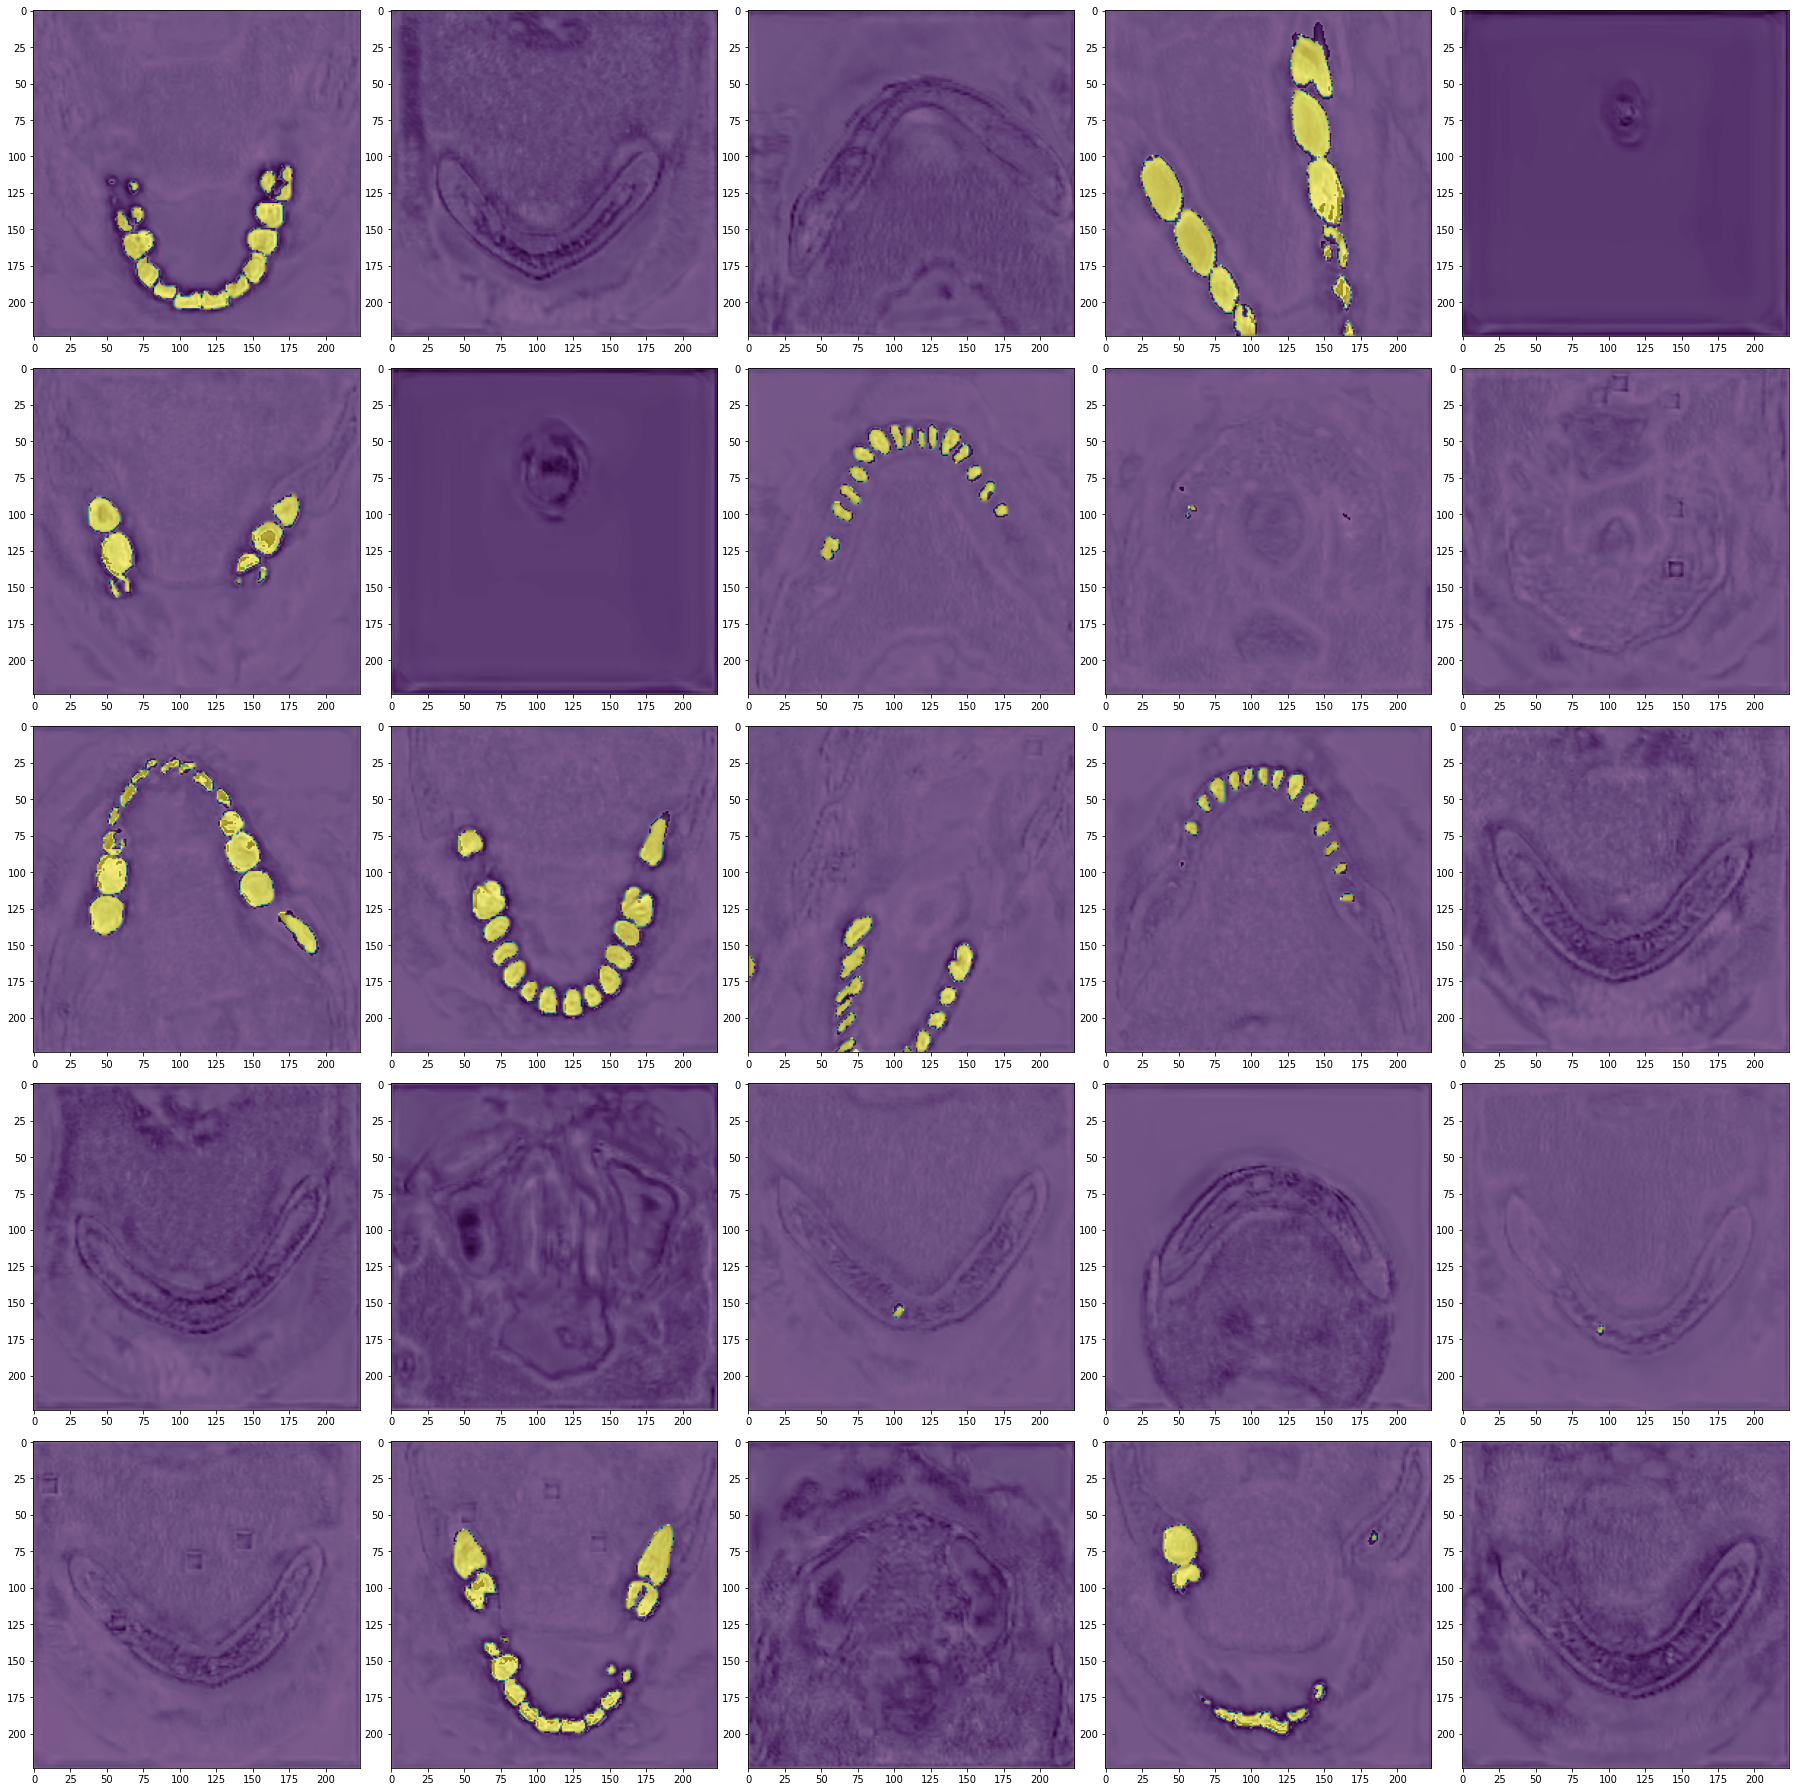

In [11]:
train_image, train_mask = next(iter(train_dataset_loader))
train_image = train_image.to(CFG.device, dtype=torch.float)
y_pred = model(train_image)
y_pred_1 = y_pred.cpu()
y_pred_2 = y_pred_1.detach().numpy()
train_image = train_image.cpu().detach().numpy()
def plot_batch(imgs, msks, img_number, size):
    plt.figure(figsize=(size*size, img_number))
    for idx in range(img_number):
        plt.subplot(round(img_number/size),size, idx+1)
        img = imgs[idx,]
        msk = msks[idx,].numpy()
        plt.imshow(img, cmap='bone')
        plt.imshow(msk, alpha=0.6)
    plt.tight_layout()
    plt.show()
plot_batch(y_pred_2.squeeze(1).astype('uint8'), train_mask.squeeze(1), 25, 5)
torch.cuda.empty_cache()

img_path_list = os.listdir(img_path)
len_list = len(img_path_list)
img_path_list = img_path_list[round(0.8*len_list)+1:]
im_array = []
mask_array = []
for i in img_path_list:
    img_file = os.path.join(img_path,i)
    mask_file = os.path.join(mask_path,i)
    for j in tqdm(os.listdir(img_file)): 
        im = cv2.resize(cv2.imread(os.path.join(img_file,j)),(CFG.img_size[0],CFG.img_size[1]))[:,:,0]
        mask = cv2.resize(cv2.imread(os.path.join(mask_file,j)),(CFG.img_size[0],CFG.img_size[1]))[:,:,0]
        im_array.append(im)
        mask_array.append(mask)
test_images = torch.from_numpy(np.array(im_array))
test_masks = torch.from_numpy(np.array(mask_array))
test_images = test_images.to(CFG.device, dtype=torch.float)
with torch.no_grad():
    preds = model(test_images.unsqueeze(1)).squeeze(1)
    preds = preds.cpu().detach().numpy()
    
test_dataset = BuildDataset(img_path, mask_path,"test",data_transforms)
test_dataset_loader = DataLoader(train_dataset, batch_size=5, num_workers=4, shuffle=True, pin_memory=True, drop_last=True)
test_images, test_masks = next(iter(test_dataset_loader))
test_images = test_images.to(CFG.device, dtype=torch.float)
test_masks = test_masks.to(CFG.device, dtype=torch.float).cpu().detach().numpy()
preds = []
#model = build_model()
#model.load_state_dict(torch.load(f"best_epoch-{fold:02d}.bin")).eval()
with torch.no_grad():
    preds = model(test_images).squeeze(1)
    preds = preds.cpu().detach().numpy()
    
def plot_batch(imgs, msks, img_number, size):
    plt.figure(figsize=(size*size, img_number))
    for idx in range(img_number):
        plt.subplot(round(img_number/size),size, idx+1)
        img = imgs[idx,]
        img = img.astype('uint8')
        msk = msks[idx,]
        plt.imshow(img, cmap='bone')
        plt.imshow(msk, alpha=0.6)
    plt.tight_layout()
    plt.show()
    
plot_batch(preds, test_masks, 5, 5)

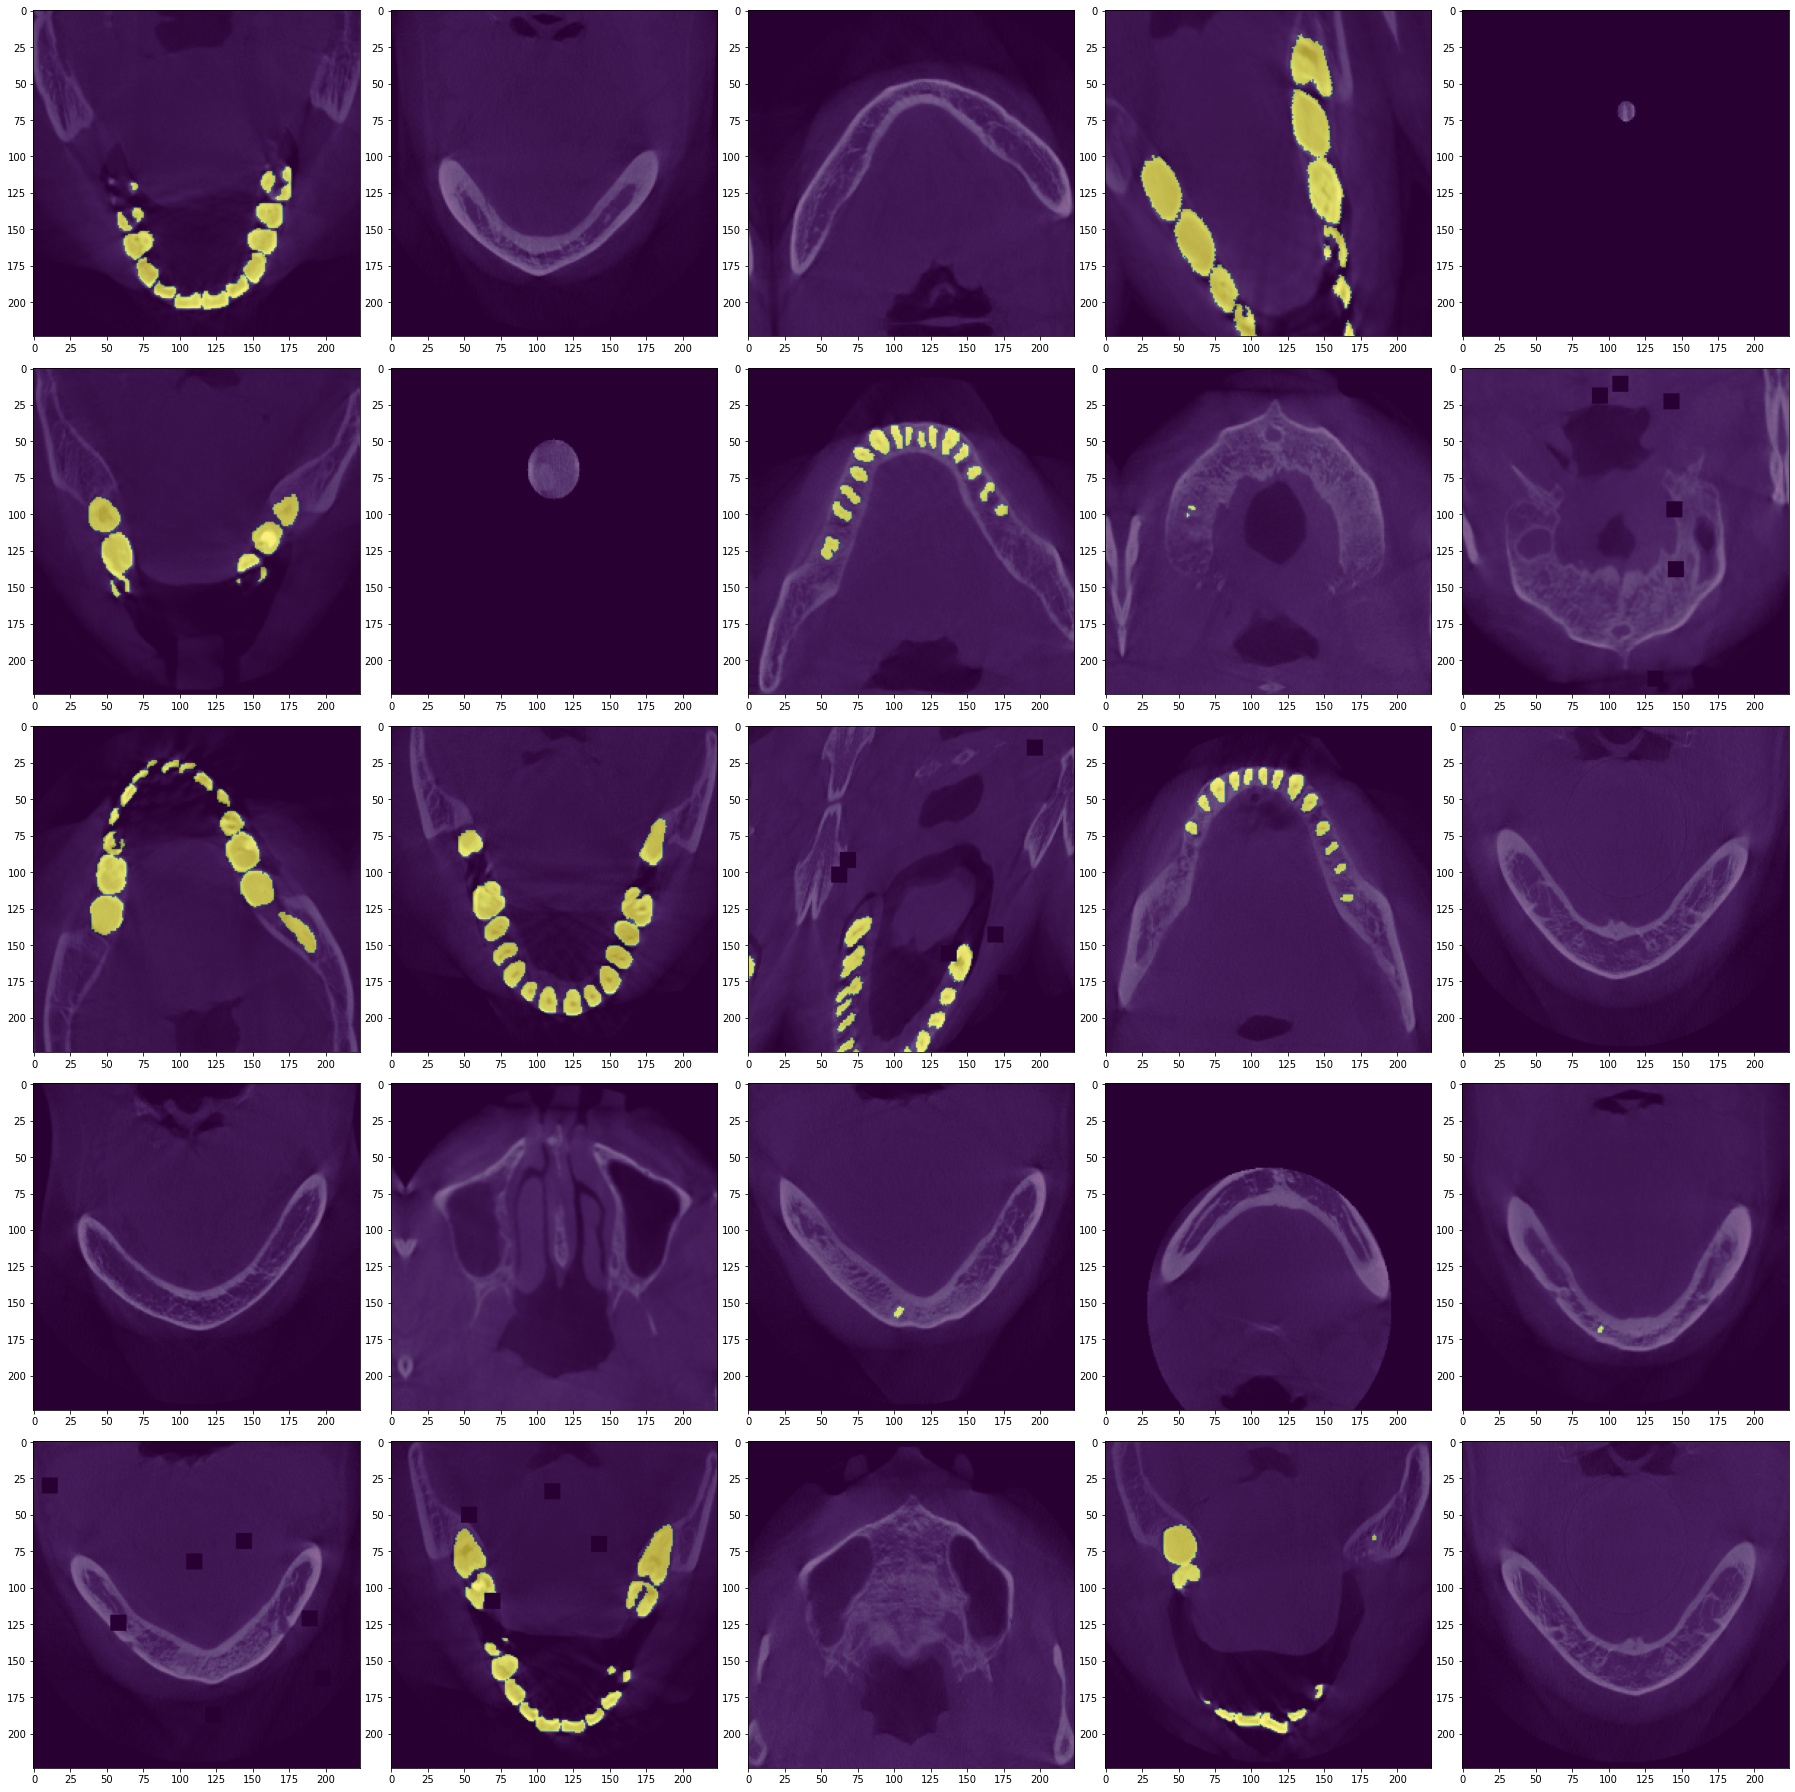

In [12]:
plot_batch(train_image.squeeze(1).astype('uint8'), train_mask.squeeze(1), 25, 5)